# Opis problemu

Celem niniejszej pracy jest budowa modelu scoringowego do oceny zdolności kredytowej indywidualnych klientów Lending Club.

Budowa modelu scoringowego jest jedną z najważniejszych i bardzo często najbardziej pracochłonną fazą projektowania całego systemu scoringowego. Faza ta obejmuje następujące czynności: wybór populacji bazowej (próby uczącej), określenie „dobrych” i „złych” klientów, analizę danych kredytowych oraz dobór właściwych predyktorów i odpowiednich ich atrybutów (grupowanie atrybutów, przekodowanie zmiennych). Etap ten obejmuje również wybór odpowiedniej metody estymacji modelu oraz przypisanie atrybutom predyktorów właściwych ocen punktowych, konstrukcję karty scoringowej oraz cały proces walidacji modelu (ocena jakości klasyfikacyjnej oszacowanego modelu, analiza właściwości prognostycznych).

Do budowy modeli scoringowych można zastosować zarówno metody statystyczne, jak i metody data mining. W ramach pierwszej grupy najczęściej wybieraną metodą jest regresja logistyczna. Z kolei najpopularniejszymi metodami eksploracji danych używanymi w scoringu są: sieci neuronowe, drzewa wzmacniane gradientowo (gradient boosted trees), losowy las (random forest) oraz metoda maszyn wektorów nośnych (suport vector machines).

Metody statystyczne charakteryzują się prostotą interpretacji, łatwością opisania siły i kierunku wpływu poszczególnych zmiennych na model. Bardzo ważną zaletą regresji logistycznej jest możliwość przekształcenia uzyskanego wzoru do formatu karty skoringowej, co ułatwia zrozumienie zbudowanego modelu nawet osobom niemających specjalistycznej wiedzy z obszaru analityki danych. Z kolei metody data mining działające na zasadzie „czarnej skrzynki”, są dużo bardziej skomplikowane, przez co praktyczna interpretacja parametrów modelu jest niemożliwa. Odznaczają się jednak większą siłą predykcyjną, gdyż umożliwiają modelowanie nieliniowych wzorców bez potrzeby implementowania dodatkowych zmiennych reprezentujących zidentyfikowane interakcje.

W  pracy postanowiono porównać skuteczność 6 metod klasyfikacji służących do budowy modeli scoringowych: regresji logistycznej, drzew decyzyjnych, lasów losowych, sieci neuronowych, algorytmu XGBoost oraz klasyfikatora zespołowego złożonego z trzech algorytmów. Do porównania jakości klasyfikacji zastosowanych metod użyto krzywej ROC i miary AUC. Dodatkowo dla modelu regresji logistycznej z uwagi na pewne własności statystyczne pozwalające na interpretowanie ocen parametrów, zbudowano kartę scoringową oraz wyznaczono optymalny punkt odcięcia. Z kolei, dla najbardziej skutecznego z modeli data mining za pomocą wartości SHAP wyznaczono najbardziej istotne cechy kredytobiorcy oraz określono siłę i kierunek ich wpływu na zmienną prognozowaną (zdolność kredytową).

# Import biblotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from xverse.transformer import MonotonicBinning
from xverse.ensemble import VotingSelector
import joypy
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
from collections import OrderedDict
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

# Wczytanie danych

Zbiór danych podlegający analizie składa się z 466 tys. wierszy (kredytobiorców) oraz 72 kolumn (cech kredytobiorców). Do dalszej analizy wykorzystano losową próbę 20 tys. obserwacji ze względu na pewne ograniczenia techniczne przetwarzania danych w ramach dostępnego sprzętu komputerowego.

In [2]:
df = pd.read_csv('Lending_Club_2007-2014.csv', low_memory=False) 
df.shape

(466285, 72)

In [3]:
df = df.sample(n=20000, random_state=61)
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
298488,298488,28623683,31156847,20000,20000,20000.0,36 months,11.67,661.14,B,B4,Group Supervisor,4 years,RENT,67000.0,Source Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,898xx,NV,33.19,0.0,Oct-95,0.0,NaN,NaN,36.0,0.0,26971,53.9,46.0,w,12503.22,12503.22,9917.10000,9917.10,2420.32,0.0,Jan-16,661.14,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,100389.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,NaN,NaN,NaN
368406,368406,17734223,19866736,11000,11000,11000.0,36 months,13.35,372.50,C,C2,Level 3 Tech,3 years,RENT,35360.0,Not Verified,Jun-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,314xx,GA,10.29,0.0,Aug-00,0.0,70.0,NaN,6.0,0.0,8262,47.2,14.0,f,5740.42,5740.42,7077.50000,7077.50,1817.92,0.0,Jan-16,372.50,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,8262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17500.0,NaN,NaN,NaN
266547,266547,33350086,35993298,6000,6000,6000.0,36 months,6.03,182.62,A,A1,Facilities manager,10+ years,MORTGAGE,70000.0,Not Verified,Nov-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,993xx,WA,18.74,0.0,May-81,0.0,NaN,NaN,15.0,0.0,5727,6.4,27.0,w,3794.28,3794.28,2554.67000,2554.67,348.95,0.0,Jan-16,182.62,Feb-16,Oct-14,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,159477.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90000.0,NaN,NaN,NaN
129483,129483,5624874,7007059,21250,21250,21250.0,36 months,10.16,687.28,B,B1,NJDOT,10+ years,RENT,55000.0,Source Verified,Jun-13,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 06/03/13 > Consolidate all...,debt_consolidation,Lifesaver,077xx,NJ,22.32,0.0,Aug-91,0.0,NaN,80.0,9.0,1.0,17626,51.4,19.0,f,4004.12,4004.12,20618.24000,20618.24,3372.36,0.0,Jan-16,687.28,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,27808.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34300.0,NaN,NaN,NaN
167900,167900,3217464,3959992,18550,18550,18525.0,36 months,13.11,626.01,B,B4,reliablechurchill,10+ years,RENT,50500.0,Verified,Feb-13,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 01/28/13 > this loan will ...,debt_consolidation,bailing me out,212xx,MD,31.25,0.0,Mar-00,0.0,26.0,NaN,6.0,0.0,14088,80.5,23.0,w,0.00,0.00,22065.88979,22036.16,3515.89,0.0,Feb-15,7672.10,NaN,Jan-16,0.0,26.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,39713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17500.0,NaN,NaN,NaN


# Opis danych

In [4]:
dic = pd.read_excel('C:\pythons\lending-club-loan-data/LCDataDictionary.xlsx', nrows=151)
dic.Description = dic.Description.str.strip()

dictionary = {}
for variable, definition in zip(dic.LoanStatNew.str.strip(), dic.Description.str.strip()):
    definition = definition.replace('\n', ', ')
    dictionary[variable] = definition

dictionary['verification_status_joint'] = dictionary['verified_status_joint']    
    
for i, col in enumerate(df.columns):
    print('{:3}:{:42}: {}'.format(i, col, dictionary.get(col)))

  0:Unnamed: 0                                : None
  1:id                                        : A unique LC assigned ID for the loan listing.
  2:member_id                                 : A unique LC assigned Id for the borrower member.
  3:loan_amnt                                 : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
  4:funded_amnt                               : The total amount committed to that loan at that point in time.
  5:funded_amnt_inv                           : The total amount committed by investors for that loan at that point in time.
  6:term                                      : The number of payments on the loan. Values are in months and can be either 36 or 60.
  7:int_rate                                  : Interest Rate on the loan
  8:installment                               : The monthly payment owed by the borrower if 

# Eksploracja danych

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 298488 to 306416
Data columns (total 72 columns):
Unnamed: 0                     20000 non-null int64
id                             20000 non-null int64
member_id                      20000 non-null int64
loan_amnt                      20000 non-null int64
funded_amnt                    20000 non-null int64
funded_amnt_inv                20000 non-null float64
term                           20000 non-null object
int_rate                       20000 non-null float64
installment                    20000 non-null float64
grade                          20000 non-null object
sub_grade                      20000 non-null object
emp_title                      18767 non-null object
emp_length                     19062 non-null object
home_ownership                 20000 non-null object
annual_inc                     20000 non-null float64
verification_status            20000 non-null object
issue_d                        20000 n

In [6]:
desc = df.describe()
desc.apply(lambda x: round(x, 1))

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,19999.0,19999.0,9268.0,2709.0,19999.0,19999.0,20000.0,19985.0,19999.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,19994.0,4168.0,20000.0,0.0,0.0,0.0,19999.0,16976.0,16976.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16976.0,0.0,0.0,0.0
mean,234267.6,13130123.0,14657105.9,14337.5,14314.6,14254.5,13.9,433.2,73493.3,17.2,0.3,0.8,33.8,74.8,11.2,0.2,16275.1,56.3,24.9,4389.5,4387.8,11563.8,11501.6,2583.9,0.7,3176.3,0.0,42.5,1.0,NaN,NaN,NaN,0.0,153.2,138413.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30280.9,NaN,NaN,NaN
std,134395.8,10895828.9,11685098.8,8354.6,8342.4,8366.9,4.3,246.4,71194.3,7.8,0.8,1.1,21.6,30.4,5.0,0.5,19739.2,23.7,11.6,6352.1,6350.1,8371.9,8367.7,2468.8,5.6,5647.9,0.1,21.9,0.0,NaN,NaN,NaN,0.1,1402.9,153233.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29835.6,NaN,NaN,NaN
min,1.0,55521.0,83974.0,800.0,800.0,0.0,5.4,23.3,3000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
25%,117400.8,3675435.2,4431809.2,8000.0,8000.0,8000.0,11.0,254.9,45000.0,11.4,0.0,0.0,16.0,53.0,8.0,0.0,6466.5,39.6,16.0,0.0,0.0,5503.4,5460.0,946.6,0.0,312.6,0.0,25.0,1.0,NaN,NaN,NaN,0.0,0.0,28041.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13600.0,NaN,NaN,NaN
50%,234329.0,10129551.0,11964100.0,12000.0,12000.0,12000.0,13.7,378.0,62000.0,16.8,0.0,0.0,30.0,77.0,10.0,0.0,11749.0,57.9,23.0,330.7,330.7,9333.7,9266.6,1824.1,0.0,552.3,0.0,42.0,1.0,NaN,NaN,NaN,0.0,0.0,79436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22700.0,NaN,NaN,NaN
75%,350861.8,20751552.2,23014395.8,20000.0,20000.0,19975.0,16.3,570.5,89000.0,22.8,0.0,1.0,49.0,102.0,14.0,0.0,20418.0,74.8,32.0,7281.7,7278.2,15510.1,15425.2,3322.7,0.0,3325.5,0.0,59.0,1.0,NaN,NaN,NaN,0.0,0.0,207251.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37700.0,NaN,NaN,NaN
max,466247.0,37841931.0,40605012.0,35000.0,35000.0,35000.0,26.1,1402.2,7500000.0,40.0,21.0,32.0,134.0,119.0,54.0,13.0,661711.0,180.3,99.0,31067.5,31067.5,54025.4,53986.9,21952.0,294.7,35723.8,3.0,137.0,1.0,NaN,NaN,NaN,2.0,75081.0,3128834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,778500.0,NaN,NaN,NaN


Główne wnioski:

-średnia wielkość kredytu wynosi USD 14 337<br>
-średnia stopa procentowa 13.9%<br>
-średnia miesięczna rata wynsi USD 433.2<br>
-średni dochód kredytobiorcy wynosi prawie USD 73 500<br>

# Rozkład empiryczny stopy procentowej oraz wielkości kredytu

       loan_amnt  int_rate
count    20000.0   20000.0
mean     14337.5      13.9
std       8354.6       4.3
min        800.0       5.4
25%       8000.0      11.0
50%      12000.0      13.7
75%      20000.0      16.3
max      35000.0      26.1


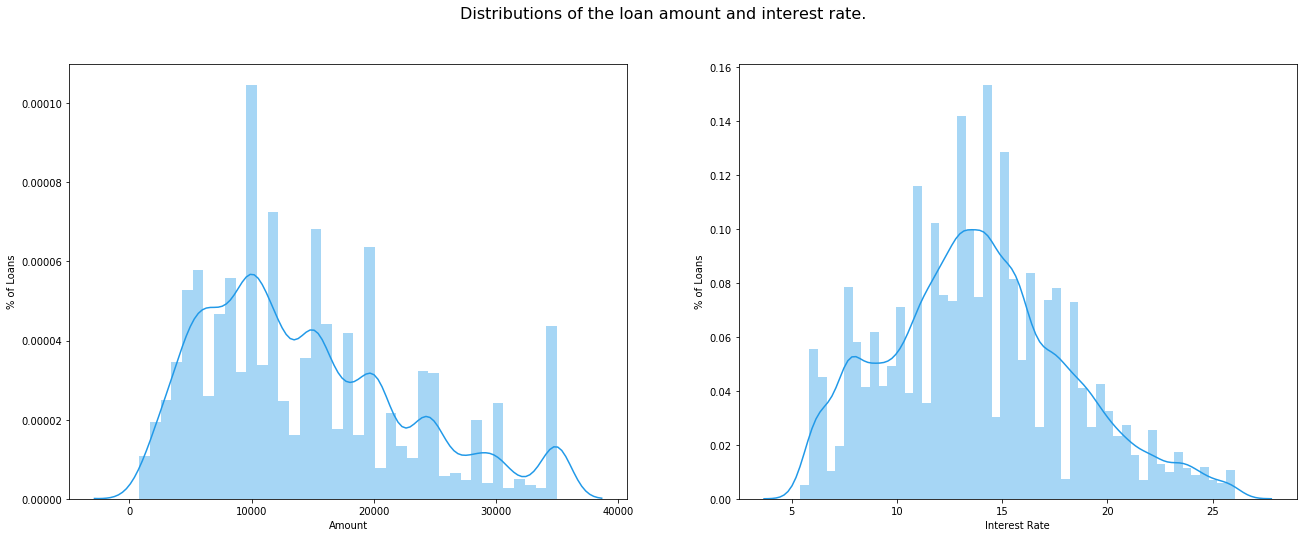

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
plt.suptitle('Distributions of the loan amount and interest rate.', fontsize=16)
sns.distplot(df.loan_amnt.values, color='#2199e8', ax=ax[0])
sns.distplot(df.int_rate.values, color='#2199e8', ax=ax[1])
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('% of Loans')
ax[1].set_xlabel('Interest Rate')
ax[1].set_ylabel('% of Loans')

print(df[['loan_amnt', 'int_rate']].describe().apply(lambda x: round(x, 1)))

Główne wnioski:

-klienci najczęściej zaciągają pożyczkę o wielkości USD 10 000. Rozkład wielkości kredytu jest prawoskośny<br>
-najmniejsza i największa pożyczka wynosi odpowiednio: USD 800 i USD 35 000<br>
-rozkład stopy procentowej jest również prawoskośny<br>
-najmniejsza i największa stopa procentowa wynosi odpowiednio: 5,4% i 26,1%

In [19]:

def display_count(plot):
    for p in plot.patches:
        plot.annotate(s = p.get_height(), 
                      xy = (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 8), 
                      textcoords = 'offset points',
                      color='black',
                      fontsize=12)

issue_year
2007     7956.000000
2008     7812.844037
2009     9949.178404
2010    10547.117296
2011    11986.787975
2012    13364.513313
2013    14803.485535
2014    14877.749926
Name: loan_amnt, dtype: float64

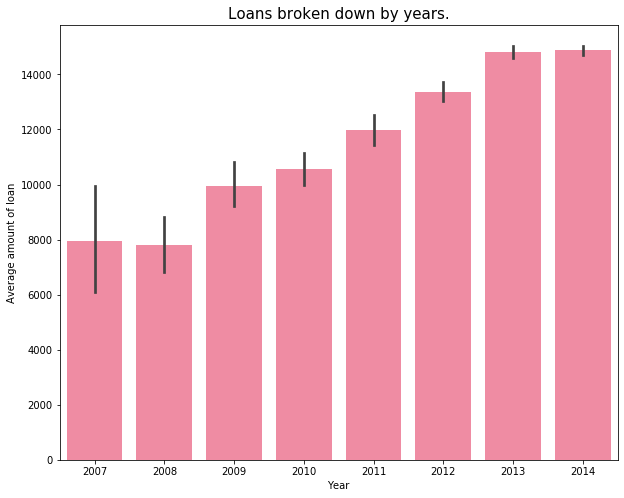

In [20]:
df['issue_year'] = pd.to_datetime(df.issue_d, format= '%b-%y').dt.year

plt.figure(figsize=(10, 8))
sns.barplot('issue_year', 'loan_amnt', data=df, color='#ff7b9a')
plt.title('Loans broken down by years.', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Average amount of loan')
df.groupby('issue_year')['loan_amnt'].mean()

-średnia wielkość kredytu rośnie z roku na rok (za wyjątkiem roku 2008 - kryzys subprime)<br>
-maksymalną wielkość kredytu osiągnięto w 2014 roku - USD 14 877<br>
-średnia wielkośc kredytu wzrosła o 70% od początku badanego okresu


# Eksploracja zmiennej objaśnianej

                                                    loan_status  share
Current                                                    9586  0.479
Fully Paid                                                 7922  0.396
Charged Off                                                1861  0.093
Late (31-120 days)                                          280  0.014
In Grace Period                                             135  0.007
Does not meet the credit policy. Status:Fully Paid           93  0.005
Late (16-30 days)                                            52  0.003
Does not meet the credit policy. Status:Charged...           40  0.002
Default                                                      31  0.002


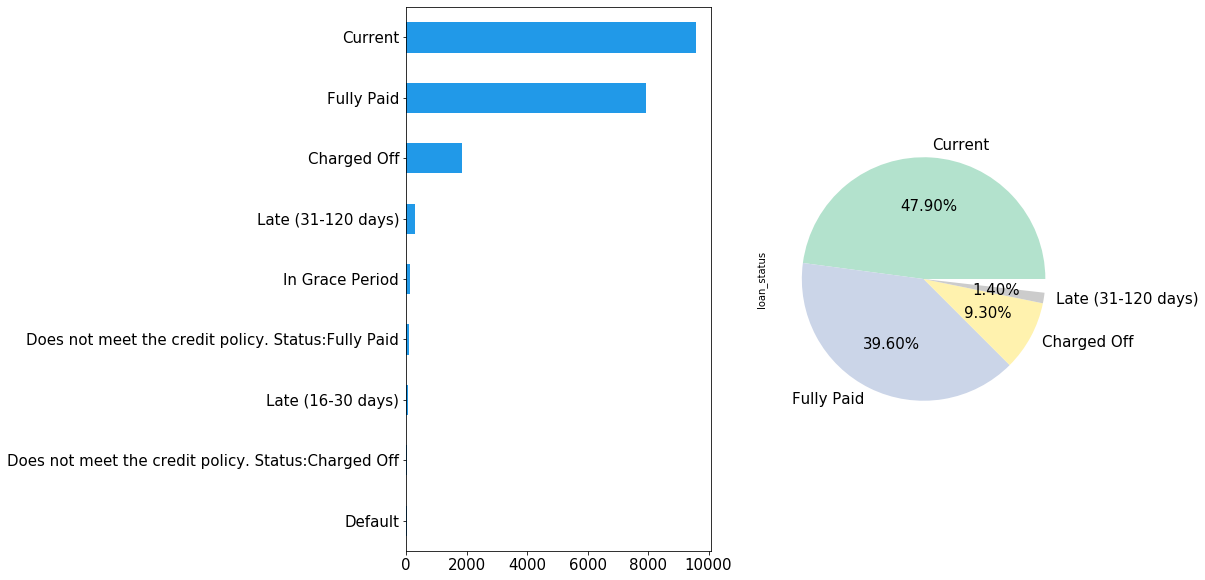

In [21]:
loan_status = pd.DataFrame(df.loan_status.value_counts())

loan_status['share'] = round(df.loan_status.value_counts() / df.loan_status.value_counts().sum(), 3)
print(loan_status)

fig, ax = plt.subplots(1, 2, figsize=(12, 10))
df.loan_status.value_counts(ascending=True).plot(kind='barh', color='#2199e8', ax=ax[0], fontsize=15)

round(df.loan_status.value_counts() / df.loan_status.value_counts().sum(), 3)[:4].plot(kind='pie', ax=ax[1], colormap='Pastel2', fontsize=15, autopct='%.2f%%')

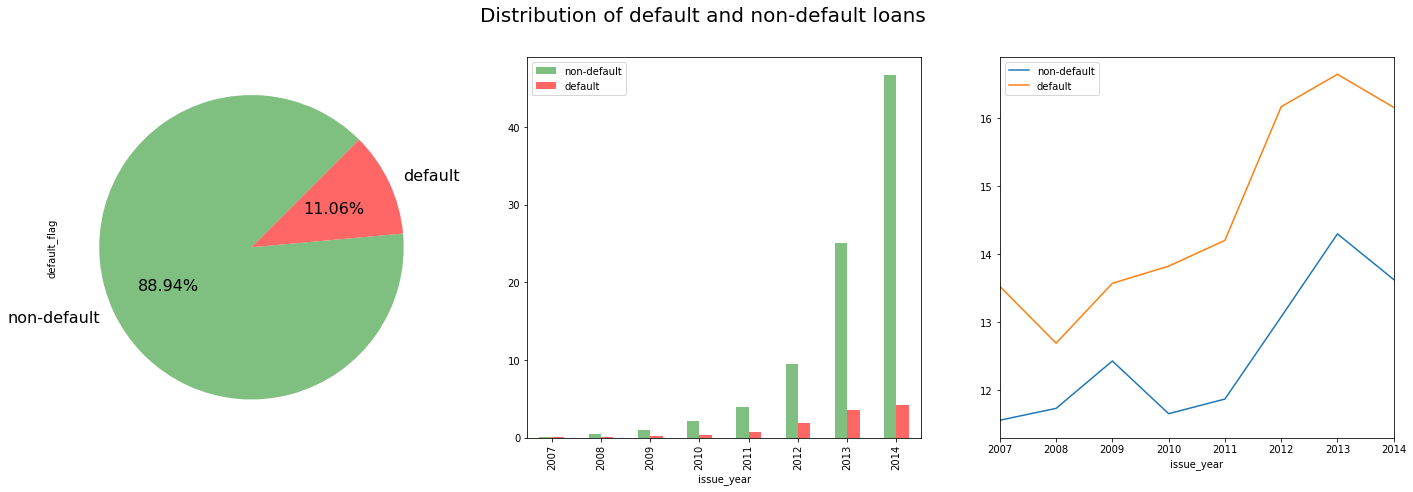

In [22]:
default = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']
df['default_flag'] = df.loan_status.apply(lambda x: 1 if x in default else 0)

default_by_year = pd.pivot_table(data=df, values='loan_amnt', index='issue_year', columns='default_flag', aggfunc=lambda x: len(x) / len(df) * 100)

fig, ax = plt.subplots(1, 3, figsize=(24, 7))
plt.suptitle('Distribution of default and non-default loans', fontsize=20)
df.default_flag.value_counts().plot.pie(labels=['non-default', 'default'],
                                          startangle=45,
                                          fontsize=16,
                                          colors=['#7FBF7F', '#FF6666'],
                                          autopct='%1.2f%%',
                                          ax=ax[0])

default_by_year.columns = ['non-default', 'default']
default_by_year.plot(kind='bar', ax=ax[1], colors=['#7FBF7F', '#FF6666'])

int_rate_by_year = df.pivot_table(values='int_rate', index=['issue_year'], columns=['default_flag'])
int_rate_by_year.columns = ['non-default', 'default']
int_rate_by_year.plot(kind='line', ax=ax[2])

-za "dobrych" kredytobiorców uznano osoby, które spłaciły kredyt oraz te, które nie zalegają z płatnościami<br>
-liczba klientów „dobrych” znacząco przewyższa liczbę klientów „złych”, którzy stanowią tylko 11% wszystkich klientów<br>
-koszt kredytu wyrażony stopą procentową jest wyższy dla "złych" kredytobiorców<br>

*W dalszym etapie pracy podjęta została próba rozwiązania problemu danych niezbilansowanych, poprzez zastosowanie jednego z algorytmów nadlosowujących (oversampling) obiekty klasy mniejszościowej – algorytmu SMOTE. Algorytm ten dogenerowuje nowe przykłady klasy mniejszościowej pomiędzy przykładami pierwotnymi za pomocą algorytmu k-najbliższych sąsiadów.


Text(0.5, 0.98, 'Type of loans by grade and subgrade')

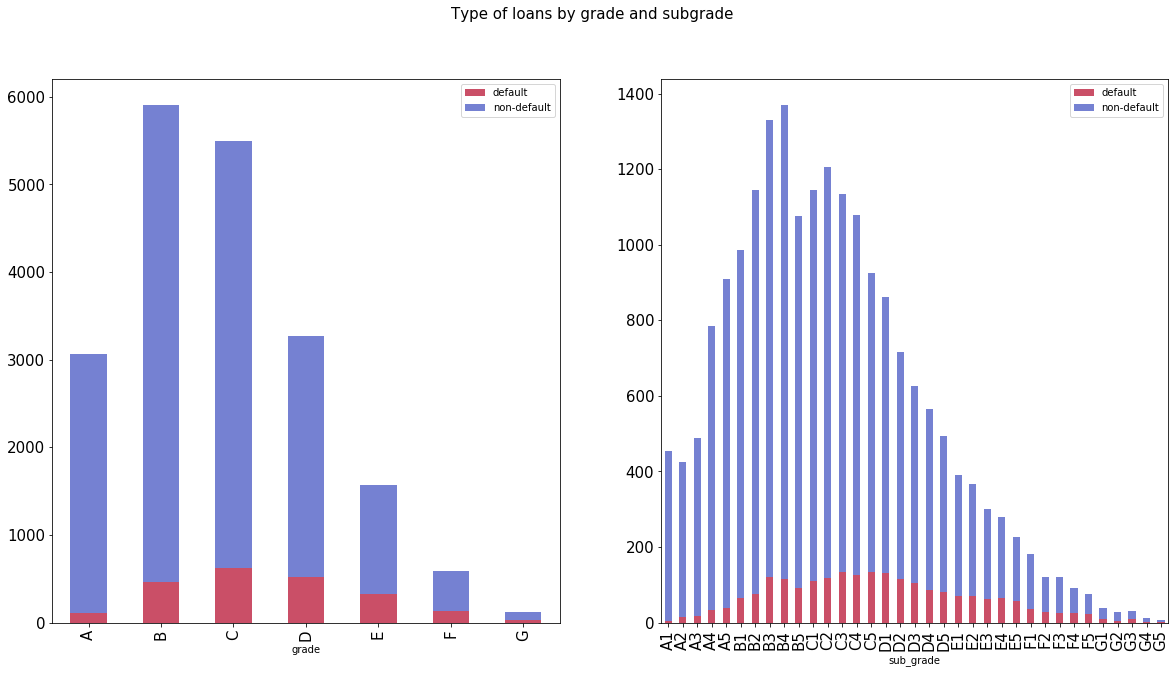

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

loan_by_grade = df.pivot_table(values='loan_amnt', index='grade', columns='default_flag', aggfunc=np.size)
loan_by_grade.columns = ['non-default', 'default']
loan_by_grade = loan_by_grade[['default', 'non-default']]
loan_by_grade.plot(kind='bar', stacked=True, cmap='coolwarm_r', alpha=0.7, fontsize=15, ax=ax[0])

loan_by_grade = df.pivot_table(values='loan_amnt', index='sub_grade', columns='default_flag', aggfunc=np.size)
loan_by_grade.columns = ['non-default', 'default']
loan_by_grade = loan_by_grade[['default', 'non-default']]
loan_by_grade.plot(kind='bar', stacked=True, cmap='coolwarm_r', alpha=0.7, fontsize=15, ax=ax[1])
plt.suptitle('Type of loans by grade and subgrade', fontsize=15)

-najwięcej kredytów przyznawanych jest kredytobiorcom kategorii B i C<br>
-najmniej kredytów przyznawanych jest kredytobiorcom kategorii F i G<br>
-największy udział "złych" kredytów ma miejsce w kategoriach F i G


count    20000.0
mean       433.2
std        246.4
min         23.3
25%        254.9
50%        378.0
75%        570.5
max       1402.2
Name: installment, dtype: float64


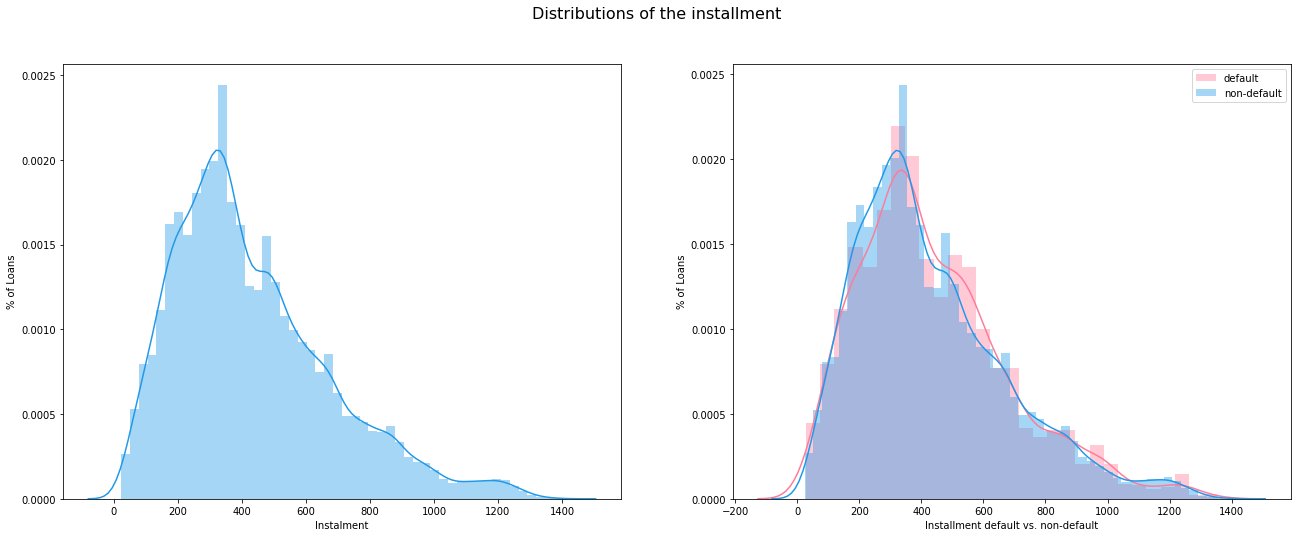

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
plt.suptitle('Distributions of the installment', fontsize=16)
sns.distplot(df.installment.values, color='#2199e8', ax=ax[0])
sns.distplot(df[df.default_flag == 1].installment, color='#ff7b9a', ax=ax[1], label='default')
sns.distplot(df[df.default_flag == 0].installment, color='#2199e8', ax=ax[1], label='non-default')
ax[0].set_xlabel('Instalment')
ax[0].set_ylabel('% of Loans')
ax[1].set_xlabel('Installment default vs. non-default') 
ax[1].set_ylabel('% of Loans')
plt.legend()

print(df['installment'].describe().apply(lambda x: round(x, 1)))

-rozkład wielkości płaconych odsetek jest prawoskośny<br>
-osoby mające problemy ze spłatą kredytu przeważnie płacą wyższe odsetki

In [7]:

# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['addr_state'], as_index=False).loan_amnt.sum()
by_interest_rate = df.groupby([ 'addr_state'], as_index=False).int_rate.mean()




# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amnt'].values.tolist()
average_interest_rates = by_interest_rate['int_rate'].values.tolist()


# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates)])
                         
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()

,state_codes,issued_loans,interest_rate
0,AK,852900,13.87
1,AL,3786925,14.23
2,AR,1950175,13.50
3,AZ,6601200,13.79
4,CA,43622900,13.70


In [8]:
for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average loan amount: ' + metrics_df['issued_loans'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Lending Clubs Issued Loans <br> (A Perspective for the Business Operations)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

-przeciętnie najwięcej kredytu zaciągają mieszkańcy Kalifornii, a także Teksasu i Noewgo Jorku<br>
-przeciętnie najwyższa stopa procentowa ustanawiana jest w Mississipi i Montanie


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 2280x1520 with 0 Axes>

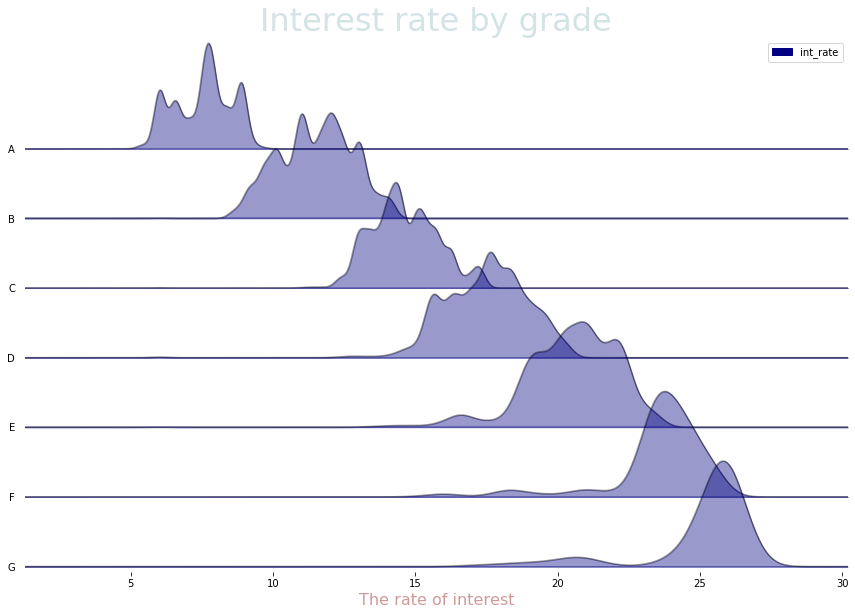

In [27]:
plt.figure(dpi= 380)

fig, axes = joypy.joyplot(df, column=['int_rate'], by="grade", ylim='own', figsize=(12,8), legend=True, color=['navy'], alpha=0.4)

# Decoration
plt.title('Interest rate by grade', fontsize=32, color='#d0e0e3', alpha=0.9)
plt.rc("font", size=20)
plt.xlabel('The rate of interest',  fontsize=16, color='darkred', alpha=0.4)
#plt.ylabel('Data Scientist', fontsize=26,  color='grey', alpha=0.8)

plt.show

- stopa procentowa rośnie wraz z coraz gorszą kategorią ryzyka kredytobiorcy<br>
- przeważnie rozkłady empiryczne stopy procentowej są lewoskośne<br>
- im słabsza kategoria ryzyka tym rozkład bardziej lewoskośny

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 2280x1520 with 0 Axes>

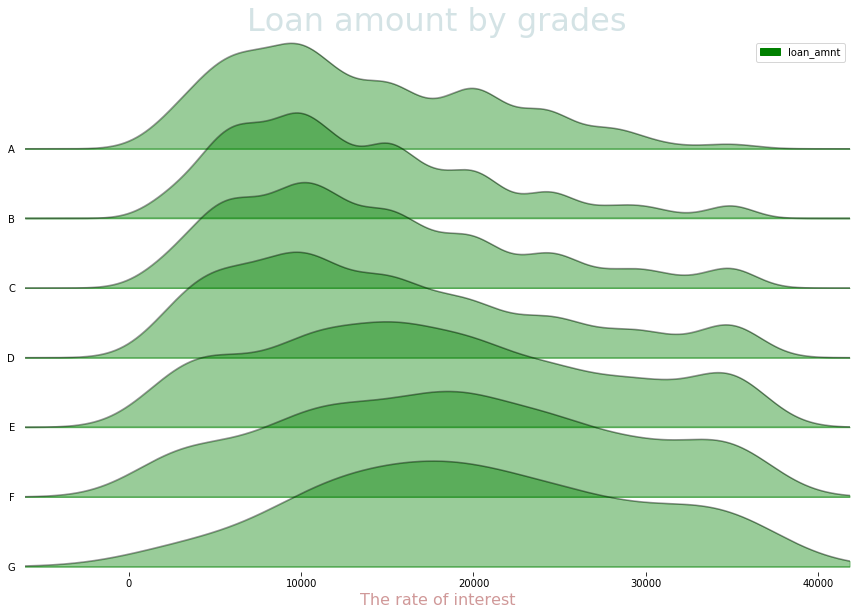

In [9]:
plt.figure(dpi= 380)

fig, axes = joypy.joyplot(df, column=['loan_amnt'], by="grade", ylim='own', figsize=(12,8), legend=True, color=['green'], alpha=0.4)

# Decoration
plt.title('Loan amount by grades', fontsize=32, color='#d0e0e3', alpha=0.9)
plt.rc("font", size=20)
plt.xlabel('The rate of interest',  fontsize=16, color='darkred', alpha=0.4)
#plt.ylabel('Data Scientist', fontsize=26,  color='grey', alpha=0.8)

plt.show

-rozkłady wielkości kredytu dla poszczególnych kategorii ryzyka jest prawoskośny<br>
-osoby o niższym ryzyku kredytowym zaciągają stosunkowo niższe pożyczki


# Czyszczenie danych

In [29]:
def check_null(df):
    number = df.isnull().sum()
    procent = df.isnull().sum()/len(df)
    concat = pd.concat([number,procent], keys=['number','procent'], axis=1)
    concat = concat.sort_values(by='procent',ascending=False)
    concat = concat[concat.procent>0]
    return concat

In [30]:
check_null(df)

,number,procent
open_acc_6m,20000,1.00000
open_rv_12m,20000,1.00000
open_il_6m,20000,1.00000
open_il_12m,20000,1.00000
open_il_24m,20000,1.00000
mths_since_rcnt_il,20000,1.00000
total_bal_il,20000,1.00000
il_util,20000,1.00000
verification_status_joint,20000,1.00000
dti_joint,20000,1.00000


In [31]:
null_data = check_null(df)
drop = null_data[null_data.procent>0.4].index
df.drop(drop, axis=1, inplace=True)
df.shape

(20000, 52)

Ze zbioru danych postanowiono usunąć wszystkie kolumny, których braki wartości przekraczały 40%.  W wyniku oczyszczania danych usunięto 20 kolumn.

In [32]:
df.describe(include='all')

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,issue_year,default_flag
count,20000.000000,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000,20000,20000.000000,20000.000000,20000,20000,18767,19062,20000,2.000000e+04,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000.000000,19999.000000,19999,19999.000000,19999.000000,19999.000000,20000.00000,19985.000000,19999.000000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,19985,20000.000000,19996,19994.000000,20000.0,20000,19999.000000,16976.000000,1.697600e+04,16976.000000,20000.000000,20000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,7,35,13179,11,5,NaN,3,91,9,2,20000,14,4162,812,47,NaN,NaN,538,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,93,NaN,84,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,36 months,NaN,NaN,B,B4,Teacher,10+ years,MORTGAGE,NaN,Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,debt_consolidation,Debt consolidation,945xx,CA,NaN,NaN,Oct-99,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,Jan-16,NaN,Jan-16,NaN,NaN,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,14494,NaN,NaN,5906,1370,201,6260,10023,NaN,7131,1686,9586,19999,1,11770,7051,232,3103,NaN,NaN,169,NaN,NaN,NaN,NaN,NaN,NaN,13029,NaN,NaN,NaN,NaN,NaN,NaN,7674,NaN,13978,NaN,NaN,20000,NaN,NaN,NaN,NaN,NaN,NaN
mean,234267.620450,1.313012e+07,1.465711e+07,14337.510000,14314.555000,14254.534582,NaN,13.873309,433.235417,NaN,NaN,NaN,NaN,NaN,7.349330e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.218582,0.287614,NaN,0.821691,11.186909,0.162858,16275.06375,56.347383,24.944897,NaN,4389.462034,4387.804691,11563.839417,11501.590870,2583.948914,0.682714,NaN,3176.319988,NaN,0.009553,1.0,NaN,0.003900,153.212064,1.384135e+05,30280.906221,2013.146500,0.110600
std,134395.829613,1.089583e+07,1.168510e+07,8354.597445,8342.359387,8366.881934,NaN,4.322981,246.401696,NaN,NaN,NaN,NaN,NaN,7.119433e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.829566,0.801153,NaN,1.133418,5.026121,0.507104,19739.15106,23.665101,11.564655,NaN,6352.129493,6350.108085,8371.949885,8367.744797,2468.825270,5.557893,NaN,5647.904636,NaN,0.104224,0.0,NaN,0.065462,1402.882605,1.532338e+05,29835.571242,1.170216,0.313644
min,1.000000,5.552100e+04,8.397400e+04,800.000000,800.000000,0.000000,NaN,5.420000,23.260000,NaN,NaN,NaN,NaN,NaN,3.000000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,1.0,NaN,0.000000,0.000000,0.000000e+00,0.000000,2007.000000,0.000000
25%,117400.750000,3.675435e+06,4.431809e+06,8000.000000,8000.000000,8000.000000,NaN,10.990000,254.875000,NaN,NaN,NaN,NaN,NaN,4.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.370000,0.000000,NaN,0.000000,8.000000,0.000000,6466.50000,39.600000,16.000000,NaN,0.000000,0.000000,5503.440000,5459.995000,946.587500,0.000000,NaN,312.620000,NaN,0.000000,1.0,NaN,0.000000,0.000000,2.804125e+04,13600.000000,2013.000000,0.000000
50%,234329.000000,1.012955e+07,1.196410e+07,12000.000000,12000.000000,12000.000000,NaN,13.670000,378.020000,NaN,NaN,NaN,NaN,NaN,6.200000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.830000,0.000000,NaN,0.000000,10.000000,0.000000,11749.00000,57.900000,23.000000,NaN,330.720000,330.720000,9333.730000,9266.600000,1824.115000,0.000000,NaN,552.280000,NaN,0.000000,1.0,NaN,0.000000,0.000000,7.943600e

# Przetwarzanie danych do formy numerycznej

In [33]:
df.emp_length.unique()
df['emp_length'] = df['emp_length'].replace({'10+ years': '10 years','< 1 year':'0 years' })
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype('float')
emp_length_fill = np.ceil(df.emp_length.mean())
df.emp_length = df.emp_length.fillna(emp_length_fill)

In [34]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format= '%b-%y')
df['months_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['earliest_cr_line_date']) / np.timedelta64(1,'M')))
df.loc[:,['months_since_earliest_cr_line','earliest_cr_line_date','earliest_cr_line']][df['months_since_earliest_cr_line']<0]
df['months_since_earliest_cr_line'][df['months_since_earliest_cr_line']<0]=df['months_since_earliest_cr_line'].max()
df['issue_d'] = pd.to_datetime(df['issue_d'], format= '%b-%y')
df['months_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['issue_d']) / np.timedelta64(1,'M')))
df['term_int'] = df['term'].apply(lambda x: x.split()[0])
df['last_pymnt_date'] = pd.to_datetime(df['last_pymnt_d'], format= '%b-%y')
df['months_since_last_pymnt_date'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['last_pymnt_date']) / np.timedelta64(1,'M')))
df['last_credit_pull_date'] = pd.to_datetime(df['last_credit_pull_d'], format= '%b-%y')
df['months_since_last_credit_pull_date'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - df['last_credit_pull_date']) / np.timedelta64(1,'M')))

In [35]:
df.drop(df[['last_credit_pull_d','last_credit_pull_date','last_pymnt_d','last_pymnt_date','issue_d','earliest_cr_line','earliest_cr_line_date','term']], axis=1,inplace=True)

In [36]:
df.loan_status.value_counts()

Current                                                9586
Fully Paid                                             7922
Charged Off                                            1861
Late (31-120 days)                                      280
In Grace Period                                         135
Does not meet the credit policy. Status:Fully Paid       93
Late (16-30 days)                                        52
Does not meet the credit policy. Status:Charged Off      40
Default                                                  31
Name: loan_status, dtype: int64

In [37]:
default_definition = ['Charged Off', 'Default', 'In Grace Perios', 'Late (31-120 days)','Late (16-30 days)','Does not meet the credit policy. Status:Charged Off']
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x in default_definition else 1)
df.loan_status.value_counts()

1    17736
0     2264
Name: loan_status, dtype: int64

In [38]:
print('Number of unique elements in each column:')
for column in df.select_dtypes(include='object').columns:
    print('{}: {}'.format(column, df[column].nunique()))

Number of unique elements in each column:
grade: 7
sub_grade: 35
emp_title: 13179
home_ownership: 5
verification_status: 3
pymnt_plan: 2
url: 20000
purpose: 14
title: 4162
zip_code: 812
addr_state: 47
initial_list_status: 2
application_type: 1
term_int: 2


In [156]:
df.title.value_counts()

Debt consolidation         8672
Other                      6953
Credit card refinancing    2662
Home improvement            626
Major purchase              213
Business                    154
Medical expenses            110
Personal Loan                94
Car financing                83
Credit Card Payoff           71
Home Improvement             68
Moving and relocation        65
Vacation                     63
Credit Card Refinance        61
Consolidate                  53
Personal                     52
Name: title, dtype: int64

In [40]:
title_names = (df['title'].value_counts() <= 50)
df['title'] = df['title'].apply(lambda x: 'Other' if title_names.loc[x] == True else x)
df.title[df['title'].str.lower().str.contains('consolidation')] = 'Debt consolidation'

In [41]:
df.drop(['zip_code','emp_title', 'url','addr_state','Unnamed: 0','id','member_id','policy_code','issue_year','default_flag'],axis=1,inplace=True)

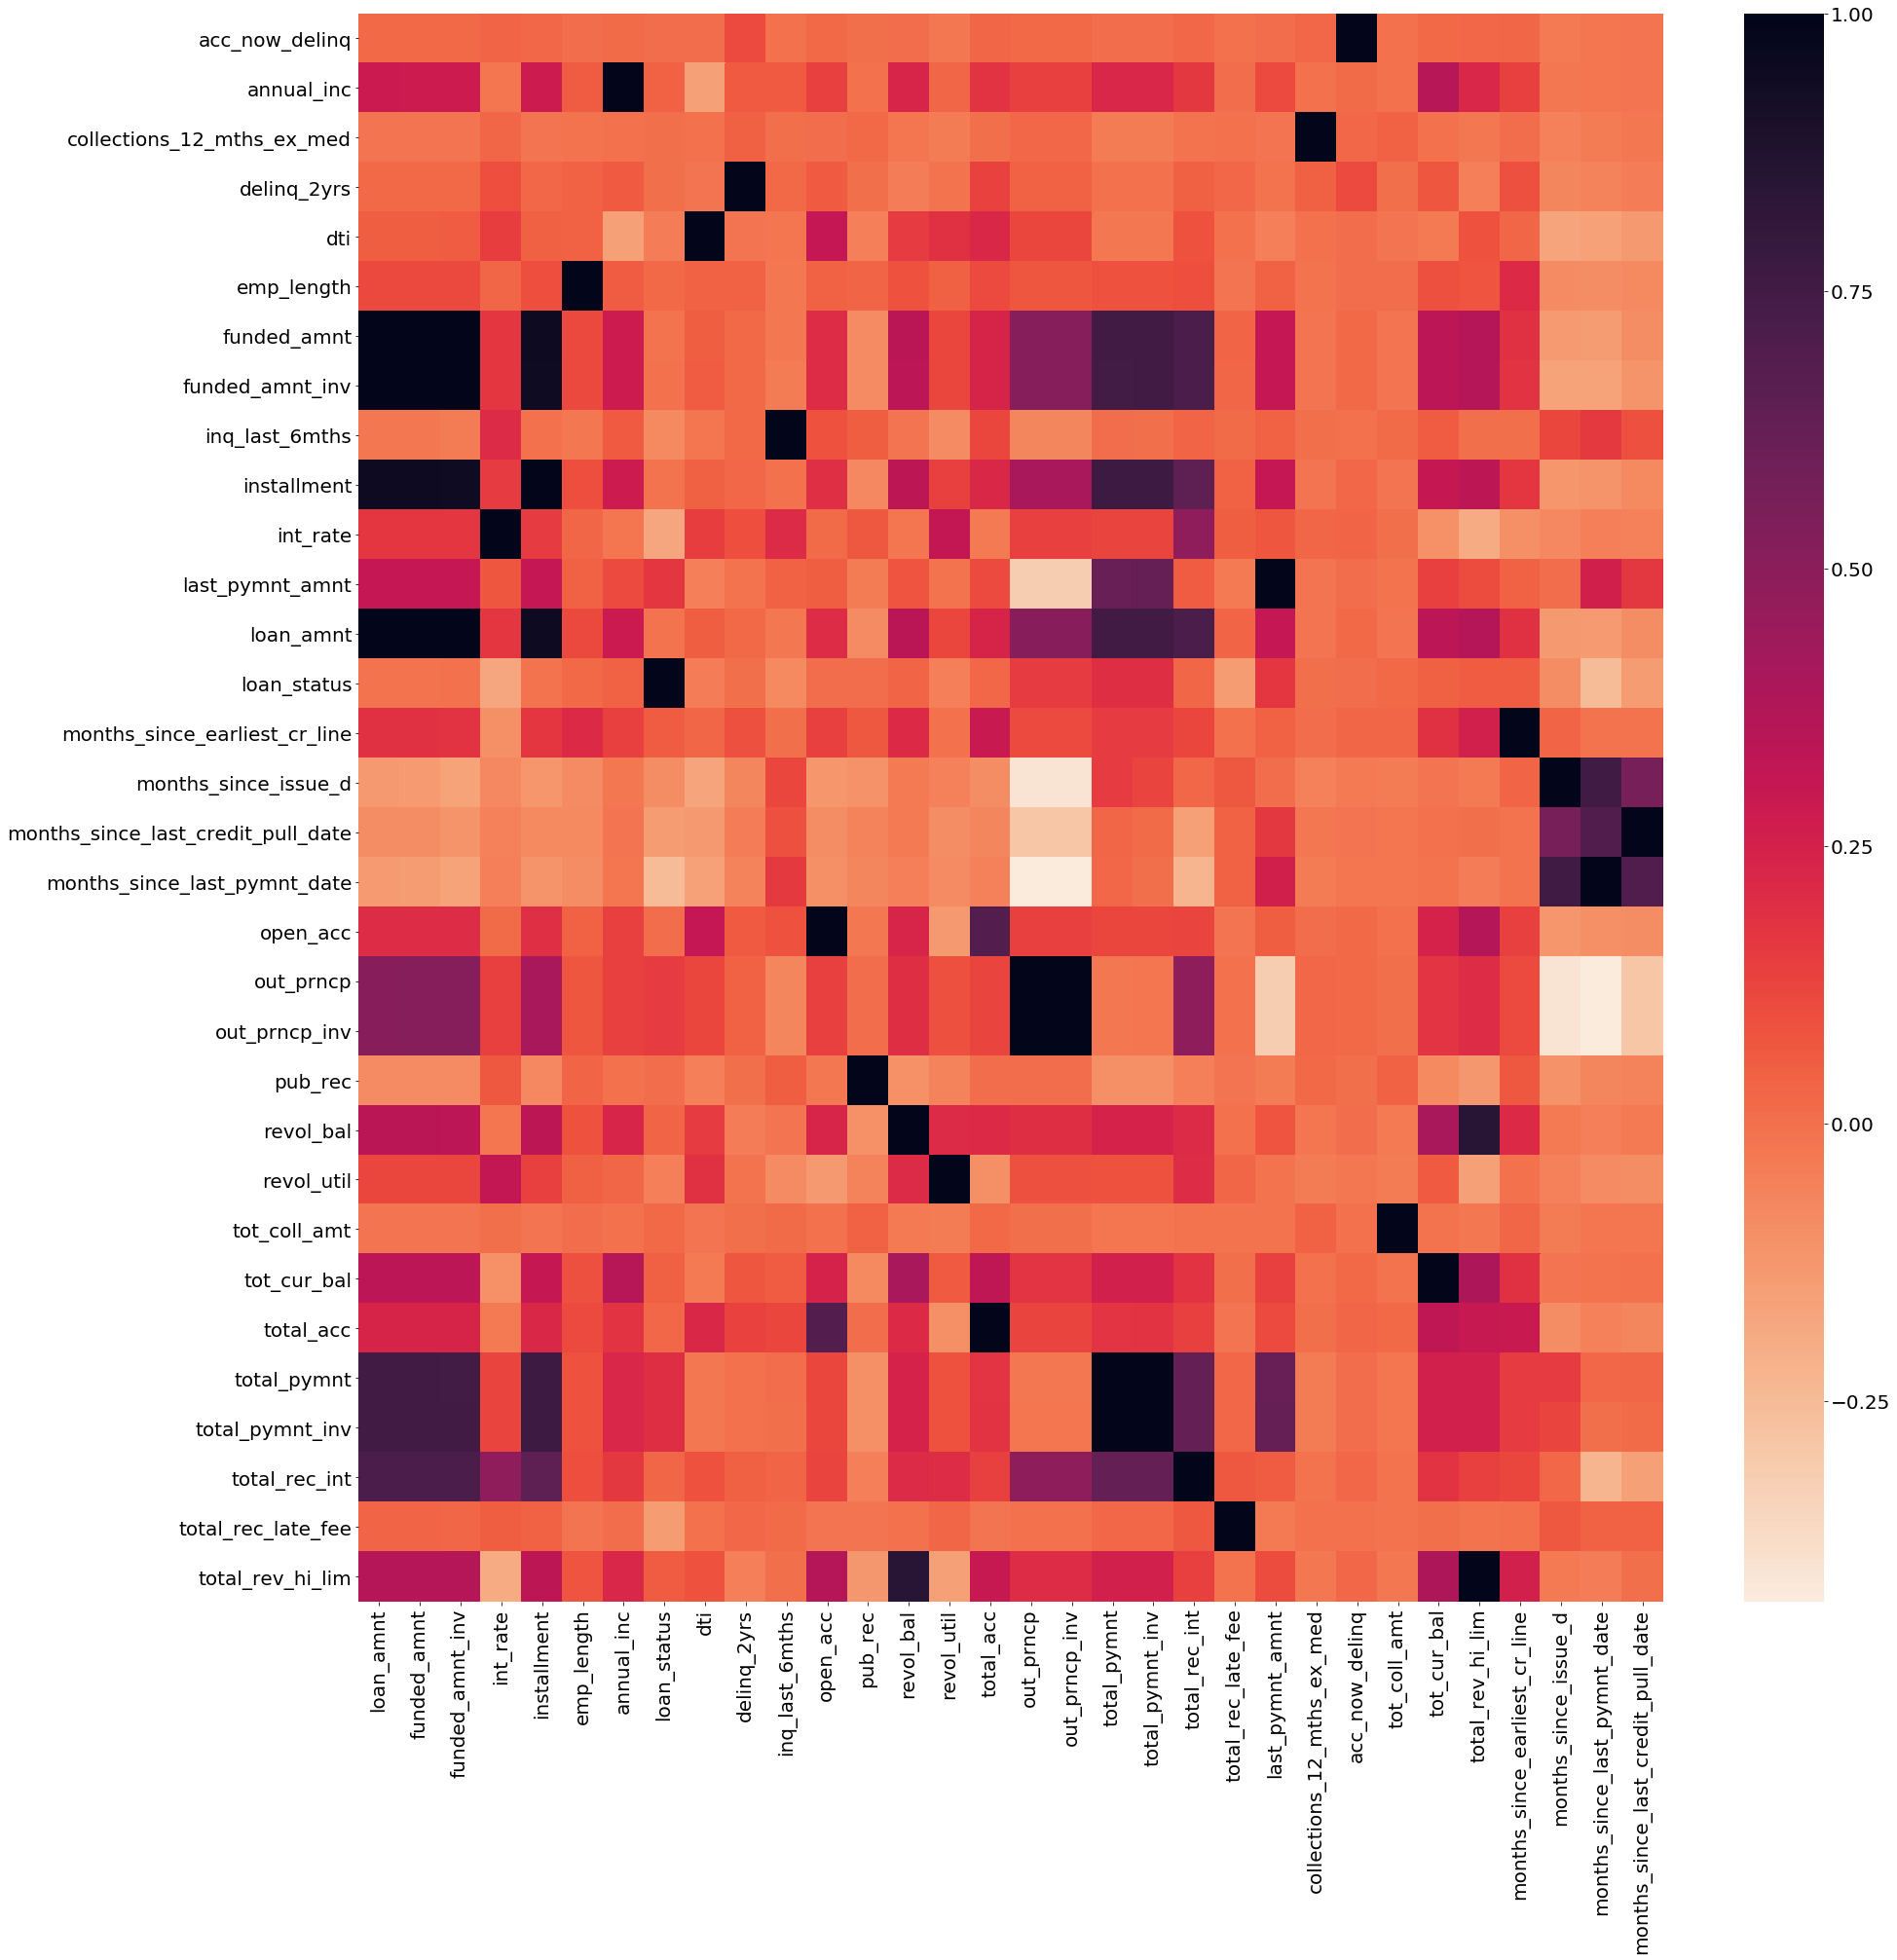

In [42]:
corr = df.corr()
corr = corr.sort_index()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, cmap='rocket_r')

In [43]:
corr['loan_status'].sort_values()

months_since_last_pymnt_date         -0.250885
int_rate                             -0.176615
total_rec_late_fee                   -0.141586
months_since_last_credit_pull_date   -0.140386
months_since_issue_d                 -0.092920
inq_last_6mths                       -0.083502
revol_util                           -0.047682
dti                                  -0.041688
installment                          -0.008721
loan_amnt                            -0.007561
funded_amnt                          -0.007098
funded_amnt_inv                      -0.004328
collections_12_mths_ex_med            0.002423
delinq_2yrs                           0.002592
open_acc                              0.006034
acc_now_delinq                        0.006823
pub_rec                               0.007379
tot_coll_amt                          0.018060
emp_length                            0.019973
total_acc                             0.026027
total_rec_int                         0.029877
revol_bal    

In [44]:
for col in df.select_dtypes(include=[np.int64, np.float64, np.int32]).columns:
    df[col] = df[col].astype('float32')
    
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in df.select_dtypes(include='float32').columns:
    df[col] = df[col].fillna(df[col].mean())

W pozostałych kolumnach, gdzie występowały braki wartości, zostały one zastąpione w przypadku cech ilościowych średnią wartości odpowiednią dla każdej zmiennej, natomiast dla danych jakościowych dominantą.

# Kategoryzacja zmiennych jakościowych

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

for col in df.select_dtypes(include='object').columns:
    if df[col].nunique()<2:
        le.fit(df[col])
        # Transform both training and testing data
        df[col] = le.transform(df[col])
        le_count += 1
    
        
       
            
print('%d columns were label encoded.' % le_count)
        

1 columns were label encoded.


In [46]:
df1 = pd.get_dummies(df)

In [47]:
df1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,months_since_earliest_cr_line,months_since_issue_d,months_since_last_pymnt_date,months_since_last_credit_pull_date,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,pymnt_plan_y,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,title_Business,title_Car financing,title_Consolidate,title_Credit Card Payoff,title_Credit Card Refinance,title_Credit card refinancing,title_Debt consolidation,title_Home Improvement,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Personal,title_Personal Loan,title_Vacation,initial_list_status_f,initial_list_status_w,term_int_36,term_int_60
298488,20000.0,20000.0,20000.0,11.67,661.140015,4.0,67000.0,1.0,33.189999,0.0,0.0,36.0,0.0,26971.0,53.900002,46.0,12503.219727,12503.219727,9917.099609,9917.099609,2420.320068,0.0,661.140015,0.0,0,0.0,0.0,100389.0,50000.0,266.0,38.0,23.0,23.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
368406,11000.0,11000.0,11000.0,13.35,372.500000,3.0,35360.0,1.0,10.290000,0.0,0.0,6.0,0.0,8262.0,47.200001,14.0,5740.419922,5740.419922,7077.500000,7077.500000,1817.920044,0.0,372.500000,0.0,0,0.0,0.0,8262.0,17500.0,208.0,42.0,23.0,23.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
266547,6000.0,6000.0,6000.0,6.03,182.619995,10.0,70000.0,1.0,18.740000,0.0,0.0,15.0,0.0,5727.0,6.400000,27.0,3794.280029,3794.280029,2554.669922,2554.669922,348.950012,0.0,182.619995,0.0,0,0.0,0.0,159477.0,90000.0,439.0,37.0,23.0,38.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
129483,21250.0,21250.0,21250.0,10.16,687.280029,10.0,55000.0,1.0,22.320000,0.0,0.0,9.0,1.0,17626.0,51.400002,19.0,4004.120117,4004.120117,20618.240234,20618.240234,3372.360107,0.0,687.280029,0.0,0,0.0,0.0,27808.0,34300.0,316.0,54.0,23.0,23.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
167900,18550.0,18550.0,18525.0,13.11,626.010010,10.0,50500.0,1.0,31.250000,0.0,0.0,6.0,0.0,14088.0,80.500000,23.0,0.000000,0.000000,22065.890625,22036.160156,3515.889893,0.0,7672.100098,0.0,0,0.0,0.0,39713.0,17500.0,213.0,58.0,34.0,23.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0


# Budowa modelu

Przed przystąpieniem do modelowania zbiór danych podzielono na zbiór treningowy oraz zbiór testowy w proporcji 70:30. Zbiór treningowy poddano przekształceniu zgodnie z algorytmem SMOTE w celu uzyskania zbilansowanej próby. Następnie na zbiorze treningowym dokonano budowy 6 modeli scoringowych w oparciu o wcześniej opisane metody. Proces uczenia każdego modelu przeprowadzono za pomocą 5-krotnego sprawdzianu krzyżowego, wydzielając dodatkowy zbiór walidacyjny do testowania skuteczności modelu. Jednocześnie zastosowano metodę przeszukiwania siatki w celu znalezienia optymalnych hiperparametrów stosowanego algorytmu klasyfikacji. Po odpowiednim wytrenowaniu modelu dokonano prognozowania na wcześniej wyodrębnionej niezależnej próbie testowej, zachowującej pierwotny rozkład zmiennej prognozowanej.

In [48]:
from sklearn.model_selection import train_test_split
X=df1.drop(['loan_status'],axis=1)
y=df1['loan_status']

In [49]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22, stratify=y)
print('Train sample size:', X_train.shape[0])
print('Test sample size: ', X_test.shape[0])
print('Validation of splitting')
print(y_train.value_counts()[1]/y_train.value_counts().sum())
print(y_test.value_counts()[1]/y_test.value_counts().sum())
print(y_train.value_counts())
#sc = StandardScaler()
#X_trains = sc.fit_transform(X_train)
#X_tests=sc.transform(X_test)
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(y_train.shape)

Using TensorFlow backend.


Train sample size: 14000
Test sample size:  6000
Validation of splitting
0.8867857142857143
0.8868333333333334
1.0    12415
0.0     1585
Name: loan_status, dtype: int64
(24830,)


In [50]:
param_grid = [{'criterion': ['entropy', 'gini'],
              'max_depth': np.arange(3, 21),
              'min_samples_leaf': [1, 3, 5, 10]}]

# build the model
tree = DecisionTreeClassifier(random_state=30)
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# build the Grid Search
gs = GridSearchCV(tree, param_grid=param_grid, cv=skf.split(X_train,y_train), scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)

# get the best estimator
tree_clf = gs.best_estimator_

# calculate predictions and probabilities
y_pred = tree_clf.predict(X_test)
y_prob = tree_clf.predict_proba(X_test)[:, 1]

# print some basic information about the model
print('-' * 30)
print('Best parameters:\n\t', gs.best_params_)
print(f'Accuracy score: {round(tree_clf.score(X_test, y_test)* 100, 4)} %')
print(f'AUC {roc_auc_score(y_test, y_prob)}')
print('-' * 30)
print('Classification report:\n', classification_report(y_test, y_pred))

# calculate false positive (FP) and true positive (TP) rate
fpr, tpr, _ = roc_curve(y_test,  y_prob)

# calculate accuracy, ROC and Gini Coefficient
accuracy = tree_clf.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_prob)
gini = 2 * roc_auc - 1

# save model performance to dictionary in order to compare with other models
models = {}
models['Decision Tree'] = [accuracy, roc_auc, gini, fpr, tpr]

------------------------------
Best parameters:
	 {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 10}
Accuracy score: 96.4667 %
AUC 0.9458196176596525
------------------------------
Classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.85       679
         1.0       0.98      0.98      0.98      5321

    accuracy                           0.96      6000
   macro avg       0.91      0.92      0.91      6000
weighted avg       0.97      0.96      0.96      6000



In [51]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'max_depth': np.arange(3, 15),
              'min_samples_leaf': [1,3, 5, 10, 20, 30],
              'n_estimators': [10, 50, 100]}]

# build a model
forest = RandomForestClassifier(criterion='gini',
                                    bootstrap=True,
                                    random_state=30,
                                    max_features='sqrt')

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# build a Grid Search
gs = GridSearchCV(forest, param_grid=param_grid, cv=skf.split(X_train,y_train), scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)

# get the best estimator
forest_clf = gs.best_estimator_

# calculate predictions and probabilities
y_pred = forest_clf.predict(X_test)
y_prob = forest_clf.predict_proba(X_test)[:, 1]

# print some basic information about the model
print('-' * 30)
print('Best parameters:\n\t', gs.best_params_)
print(f'Accuracy score: {round(forest_clf.score(X_test, y_test) * 100, 4)} %')
print(f'AUC {roc_auc_score(y_test, y_prob)}')
print('-' * 30)
print('Classification report:\n', classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test,  y_prob)

# calculate accuracy, ROC and Gini Coefficient
accuracy = forest_clf.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_prob)
gini = 2 * roc_auc - 1

models['Random Forest'] = [accuracy, roc_auc, gini, fpr, tpr]

------------------------------
Best parameters:
	 {'max_depth': 14, 'min_samples_leaf': 1, 'n_estimators': 100}
Accuracy score: 97.9667 %
AUC 0.9692517961039692
------------------------------
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.90       679
         1.0       0.98      1.00      0.99      5321

    accuracy                           0.98      6000
   macro avg       0.97      0.93      0.95      6000
weighted avg       0.98      0.98      0.98      6000



In [52]:


folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
from sklearn.linear_model import LogisticRegression

param_grid = {"C":[0.01,0.1,1,10], "penalty":["l2"]}

# build a model
log_reg = LogisticRegression(solver='liblinear', random_state=30)

# built a Grid Search
gs = GridSearchCV(log_reg, param_grid, cv=skf.split(X_train,y_train), scoring='roc_auc')
gs.fit(X_train, y_train)

# get the best estimator
log_reg_clf = gs.best_estimator_

# calculate predictions and probabilities
y_pred = log_reg_clf.predict(X_test)
y_prob = log_reg_clf.predict_proba(X_test)[:, 1]

# print some basic information about the model
print('-' * 30)
print('Best parameters:\n\t', gs.best_params_)
print(f'Accuracy score: {round(log_reg_clf.score(X_test, y_test)* 100, 4)} %')
#print(f'AUC {roc_auc_score(y_test, y_prob)}')
print('-' * 30)
print('Classification report:\n', classification_report(y_test, y_pred))
print(roc_auc_score(y_test,y_pred))
fpr, tpr, _ = roc_curve(y_test,  y_prob)

# calculate accuracy, ROC and Gini Coefficient
accuracy = forest_clf.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_prob)
gini = 2 * roc_auc - 1
models['Logistic Regression'] = [accuracy, roc_auc, gini, fpr, tpr]

# clean the workspace
del y_pred
del y_prob
del accuracy
del roc_auc
del fpr
del tpr

------------------------------
Best parameters:
	 {'C': 0.01, 'penalty': 'l2'}
Accuracy score: 97.6833 %
------------------------------
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       679
         1.0       0.98      0.99      0.99      5321

    accuracy                           0.98      6000
   macro avg       0.97      0.92      0.94      6000
weighted avg       0.98      0.98      0.98      6000

0.9162734755639353


In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
        'n_estimators': [500,1000, 1500],
        'max_depth': [2,5,10,15],
        'learning_rate' : [0.0001, 0.001, 0.01]
        }

xgb = XGBClassifier(  objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

gs = GridSearchCV(xgb, param_grid=params, scoring='roc_auc', cv=skf.split(X_train,y_train), n_jobs=-1)
gs.fit(X_train, y_train)

xbc_clf=gs.best_estimator_

y_pred = xbc_clf.predict(X_test.values)
y_prob = xbc_clf.predict_proba(X_test.values)[:, 1]

# print some basic information about the model
print('-' * 30)
print('Best parameters:\n\t', gs.best_params_)
print(f'Accuracy score: {round(xbc_clf.score(X_test.values, y_test) * 100, 4)} %')
#print(f'AUC {roc_auc_score(y_test, y_prob)}')
print('-' * 30)
print('Classification report:\n', classification_report(y_test, y_pred))
print(roc_auc_score(y_test,y_pred))

fpr, tpr, _ = roc_curve(y_test,  y_prob)

# calculate accuracy, ROC and Gini Coefficient
accuracy = xbc_clf.score(X_test.values, y_test)
roc_auc = roc_auc_score(y_test, y_prob)
gini = 2 * roc_auc - 1
models['XGBoost'] = [accuracy, roc_auc, gini, fpr, tpr]

# clean the workspace
del y_pred
del y_prob
del accuracy
del roc_auc
del fpr
del tpr

------------------------------
Best parameters:
	 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1500}
Accuracy score: 98.7333 %
------------------------------
Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       679
         1.0       0.99      1.00      0.99      5321

    accuracy                           0.99      6000
   macro avg       0.98      0.95      0.97      6000
weighted avg       0.99      0.99      0.99      6000

0.9517442628050857


In [54]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_test.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

print('\nTrain split:')
print(y_train.value_counts() / y_train.count())
print('Validation split:')
print(y_val.value_counts() / y_val.count())
print('Test split:')
print(y_test.value_counts() / y_test.count())

X_train shape: (11250, 118)
X_val shape: (3750, 118)
X_test shape: (5000, 118)
y_train shape: (5000,)
y_val shape: (3750,)
y_test shape: (5000,)

Train split:
1.0    0.886844
0.0    0.113156
Name: loan_status, dtype: float64
Validation split:
1.0    0.886667
0.0    0.113333
Name: loan_status, dtype: float64
Test split:
1.0    0.8868
0.0    0.1132
Name: loan_status, dtype: float64


In [55]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)


In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=6)

def build_model():
    model = Sequential()
    model.add(Dense(units=120, input_shape=(118,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=12, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    model.summary()
    return model

In [61]:
model = build_model()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32,callbacks=[early_stop])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 120)               14280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                7744      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                780       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 13        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
__________________________________________________

In [62]:
def make_accuracy_plot(history):
    """
    This function returns the accuracy chart of the model on the training and validation set.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=1.4)
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
def make_loss_plot(history):
    """
    This function returns the loss chart of the model on the training and validation set.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=1.4)
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


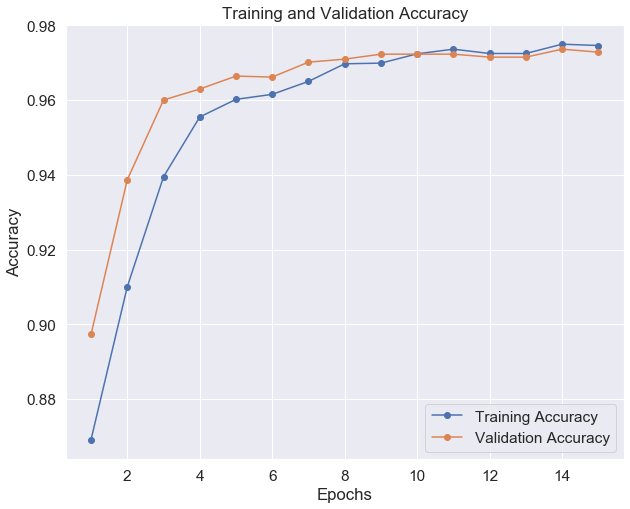

In [63]:
make_accuracy_plot(history)

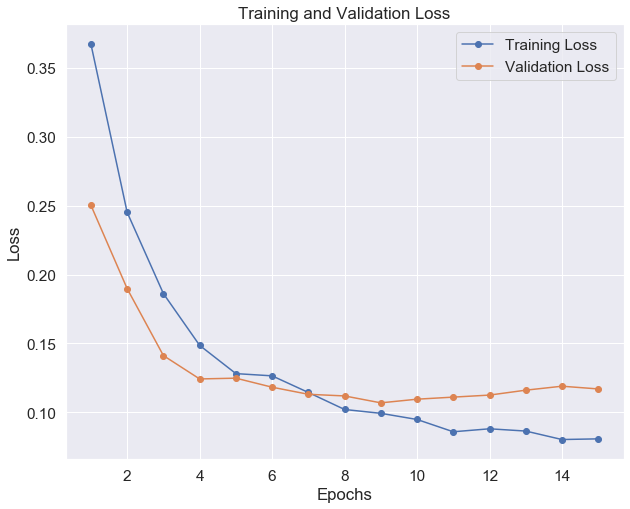

In [64]:
make_loss_plot(history)

In [65]:
from sklearn.metrics import accuracy_score

# build a model
neural_network_clf = build_model()
neural_network_clf.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val), batch_size=32)

# calculate predictions and probabilities
y_pred = neural_network_clf.predict_classes(X_test)
y_prob = neural_network_clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test,  y_prob)

# calculate accuracy, ROC and Gini Coefficient
accuracy = forest_clf.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_prob)
gini = 2 * roc_auc - 1

models['Neural Network'] = [accuracy, roc_auc, gini, fpr, tpr]

print('Classification report:\n', classification_report(y_test, y_pred))

# clean the workspace
del y_pred
del y_prob
del accuracy
del roc_auc
del fpr
del tpr

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               14280     
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                7744      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                780       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 13        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
__________________________________________________

# Ocena jakości modelu

Accuracy:
 Decision Tree          0.964667
Random Forest          0.979667
Logistic Regression    0.979667
XGBoost                0.987333
Neural Network           0.8868
Name: accuracy, dtype: object

Gini Coefficient:
 Decision Tree          0.891639
Random Forest          0.938504
Logistic Regression    0.940092
XGBoost                0.975301
Neural Network          0.91561
Name: Gini, dtype: object

AUC:
 Decision Tree           0.94582
Random Forest          0.969252
Logistic Regression    0.970046
XGBoost                0.987651
Neural Network         0.957805
Name: AUC, dtype: object


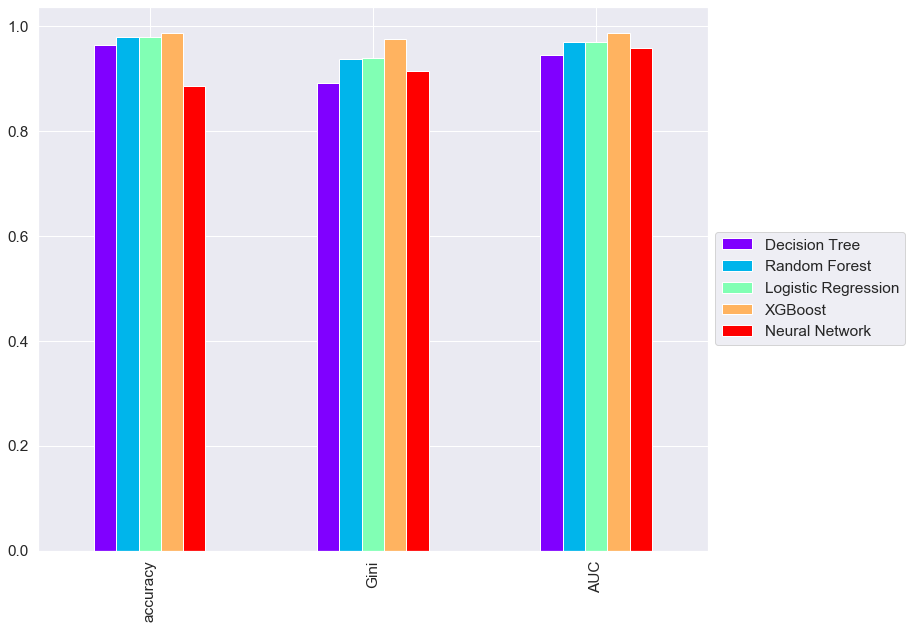

In [66]:

# make DataFrame containing information about model performance
models_df = pd.DataFrame(models, index=['accuracy', 'AUC', 'Gini', 'fpr', 'tpr'])
round(models_df,3)
# plot accuracy and AUC values
models_df.loc[['accuracy', 'Gini', 'AUC']].plot(kind='bar',
                                        cmap='rainbow', 
                                        figsize=(12, 10)).legend(bbox_to_anchor=(1, 0.6))

print('Accuracy:\n', models_df.loc['accuracy'])
print('\nGini Coefficient:\n', models_df.loc['Gini'])
print('\nAUC:\n', models_df.loc['AUC'])

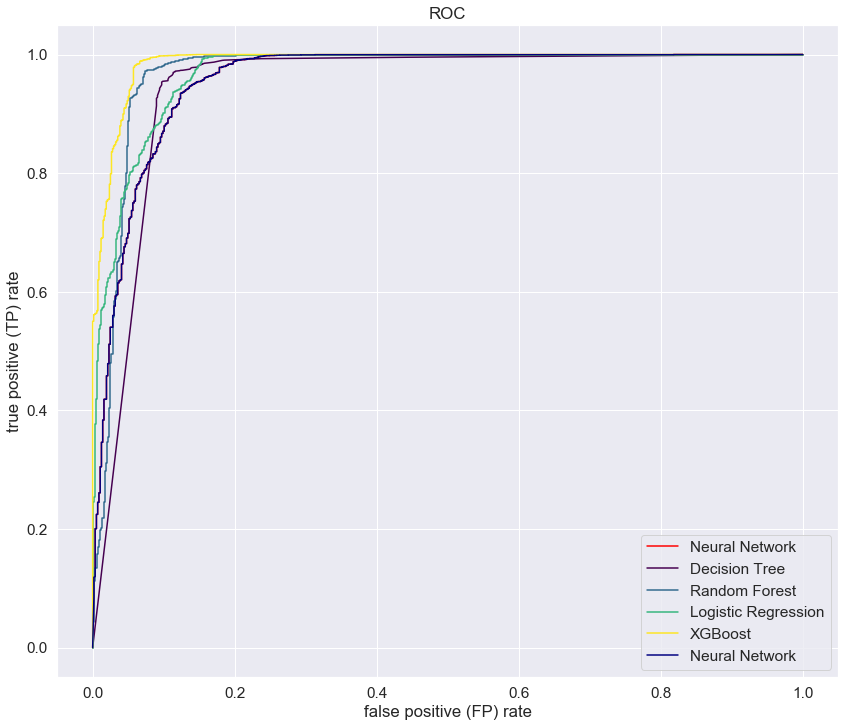

In [67]:
colors = ['#450050', '#31698E', '#36B67D', '#FDE624','navy','red']
fig = plt.figure(figsize=(14, 12))
for i in range(6):
    plt.plot(models_df.loc['fpr'][i-1], models_df.loc['tpr'][i-1], label=list(models_df.columns)[i-1], color=colors[i-1])
    plt.xlabel('false positive (FP) rate')
    plt.ylabel('true positive (TP) rate')
    plt.title('ROC')
    plt.legend(loc='lower right')

In [68]:
from sklearn.ensemble import VotingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# build a voting classifier
vc = VotingClassifier([('XGBoost', xbc_clf), ('Random Forest', forest_clf), ('Logistic Regression', log_reg_clf)], voting='soft')
vc.fit(X_train, y_train)

# calculate predictions and probabilities
y_pred = vc.predict(X_test)
y_prob = vc.predict_proba(X_test)[:, 1]

# calculate fpr, tpr, accuracy, AUC, Gini Coefficient
fpr, tpr, _ = roc_curve(y_test,  y_prob)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
gini = 2 * roc_auc - 1

print('Accuracy:', vc.score(X_test, y_test))
print('Classification report:\n', classification_report(y_test, y_pred))


models['Voting Classifier'] = [accuracy, roc_auc, gini, fpr, tpr]

Accuracy: 0.991
Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       566
         1.0       0.99      1.00      0.99      4434

    accuracy                           0.99      5000
   macro avg       0.99      0.96      0.98      5000
weighted avg       0.99      0.99      0.99      5000



,Decision Tree,Random Forest,Logistic Regression,XGBoost,Neural Network,Voting Classifier
accuracy,0.964667,0.979667,0.979667,0.987333,0.8868,0.991
AUC,0.94582,0.969252,0.970046,0.987651,0.957805,0.960247


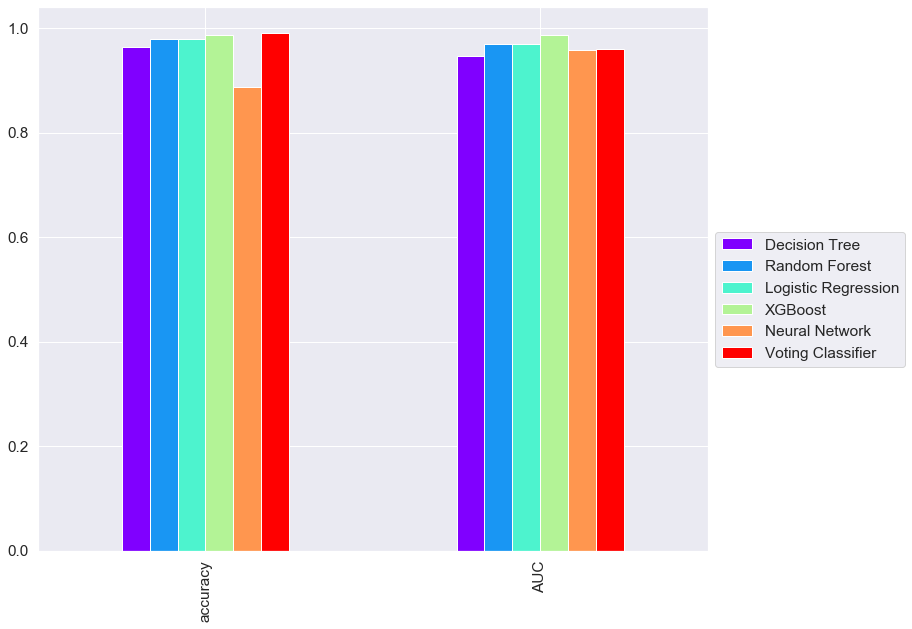

In [72]:
models_df = pd.DataFrame(models, index=['accuracy', 'AUC', 'Gini', 'fpr', 'tpr'])

models_df.loc[['accuracy', 'AUC']].plot(kind='bar',
                                        cmap='rainbow', 
                                        figsize=(12, 10)).legend(bbox_to_anchor=(1, 0.6))
models_df.loc[['accuracy', 'AUC']]

Otrzymane wyniki analiz, dokonanych przy użyciu różnych metod, porównano za pomocą krzywej ROC. Na podstawie przebiegu krzywej ROC oraz wyliczonych miar AUC stwierdzono, że wszystkim modelom udało się wychwycić zależności zawarte w danych – pole powierzchni dla krzywej ROC wynosi powyżej 0,9. Modele mają porównywalną jakość klasyfikacji, jednak największą skuteczność klasyfikacji uzyskuje model XGBoost, którego wartość AUC wynosi 0,987. Najmniej skuteczny okazał się model drzew decyzyjnych (AUC – 0,945).

# Interpretacja modelu XGBoost

Wiarygodność i trafność predykcji są kluczowe w procesie walidacji modelu, ale nie powinny być jedynymi kryteriami oceny modeli uczenia maszynowego. Coraz częściej dużą wagę przywiązuje się do interpretowalności predykcji. Po pierwsze dlatego, że traktowanie modeli data mining jak czarnych skrzynek lub magicznych wyroczni ogranicza zaufanie użytkowników do skuteczności tych metod. Po drugie, wraz z coraz powszechniejszym wykorzystaniem modeli uczenia maszynowego wzrasta liczba ich zastosowań, w których wyjaśnienie podjętej decyzji jest równie ważne co sama decyzja. Na przykład, bank ma prawny obowiązek podać powód odmowy udzielenia kredytu.

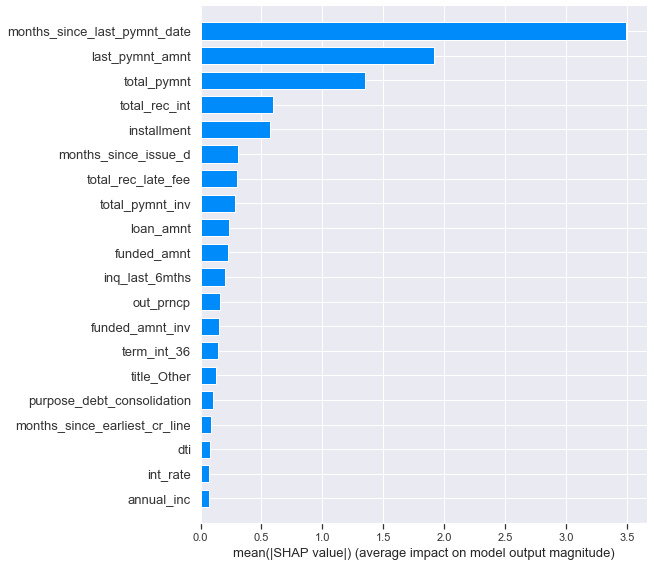

In [73]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xbc_clf)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

#shap_values = shap.TreeExplainer(xbc_clf).shap_values(X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Sumaryczne wartości SHAP mogą pokazać, w jakim stopniu każda cecha przyczyniła się do przewidywania zmiennej docelowej. Powyżej zaprezentowano wykres z globalną interpretowalnością. Wykres ten zawiera listę najbardziej znaczących zmiennych w porządku malejącym. Górne charakterystyki wnoszą najwięcej do modelu. Im niżej tym cecha ma mniejszą moc predykcyjną.

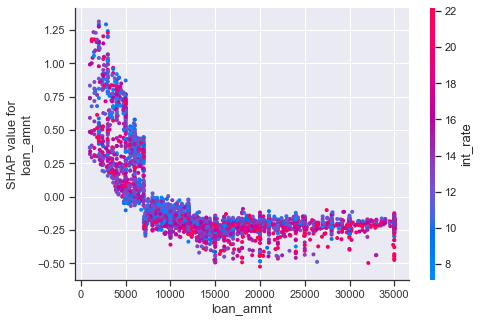

In [74]:
shap.dependence_plot('loan_amnt', shap_values, X_test, interaction_index="int_rate")

<Figure size 576x720 with 0 Axes>

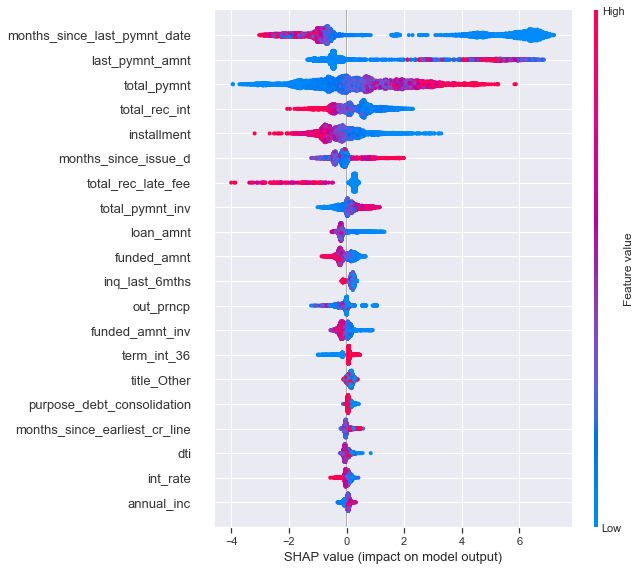

<Figure size 576x720 with 0 Axes>

In [75]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test,show=False)
#import matplotlib.pyplot as pl; f = pl.gcf() 
plt.figure(figsize=[8,10])


Kolejny wykres wartości SHAP ma na celu pokazanie kierunku i siły oddziaływania poszczególnych zmiennych na zmienną prognozowaną (zdolność kredytową).Zachowana jest ta sama kolejność zmiennych według ważności cech. Każda kropka na wykresie reprezentuje jedną obserwację w zbiorze danych (w tym wypadku zbiór testowy).

Oś pozioma na dole wykresu wskazuje, czy wpływ wartości SHAP określonych zmiennych jest związany z wyższą prognozą czy niższą (wszystko na lewo od 0 wpływa negatywnie, a wszystko na prawo pozytywnie). Indeks koloru widoczny po prawej stronie wykresu informuje jakie wartości przyjmuje dana zmienna (wysokie wartości kolor czerwony, niskie wartości kolor niebieski). Dodatkowo poprzez układ kropek możemy odczytać uproszczony rozkład określonej zmiennej. Znaczne zagęszczenie kropek w jednym miejscu oznacza, że większość obserwacji jest skupiona w tym jednym miejscu.

Wykres można interpretować w następujący sposób – pozytywnie na zdolność kredytową wpływa niskie miesięczne raty kredytowe oraz niezaleganie z płatnościami, a negatywnie wysoka stopa procentowa i duża wielkość kredytu.

<Figure size 1440x216 with 0 Axes>

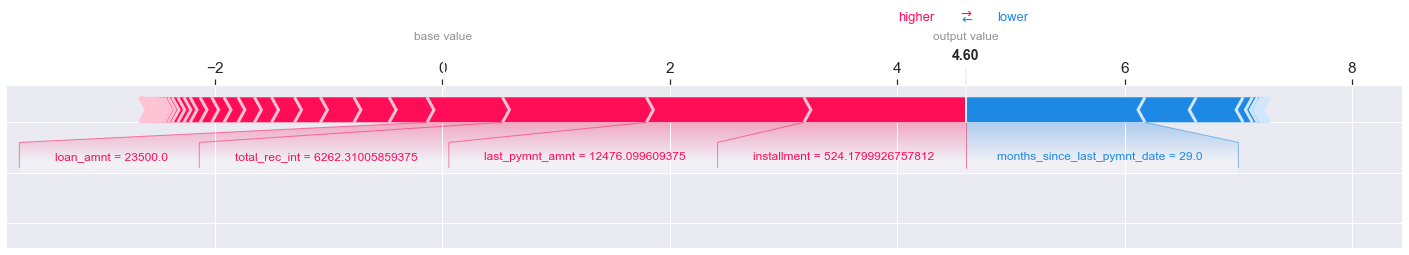

In [93]:
shap.initjs()
sns.set_style('darkgrid')
plt.figure(figsize=[20,3])
shap.force_plot(explainer.expected_value, shap_values[44], X_test.iloc[1],figsize=(25, 3),matplotlib=True)

Podczas przeliczania każda obserwacja otrzymała swój własny zestaw wartości SHAP. Dzięki temu dla każdej obserwacji możemy sprawdzić w jakim stopniu każda zmienna wpłynęła na podjęcie takiej decyzji przez model. Możemy w prosty i przejrzysty sposób wyjaśnić, dlaczego model zwrócił taką prognozę. Powyżej przedstawiono wykres SHAP dla obserwacji ze zbioru testowego

In [94]:
a = np.exp(4.60) / (1 + np.exp(4.60))
a

0.9900481981330956

Dla analizowanej obserwacji (klienta) wartość prognozowana (output value) wynosi 4.60 i jest ona zapisana w postaci log-odds. Aby przejść do formatu prawdopodobieństwa należy dokonać przekształcenia za pomocą wzoru: 

𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦=exp(𝛼)/1+exp(𝛼)

Wówczas prawdopodobieństwo braku spłaty zaciągniętego kredytu dla tego klienta wynosi 99%.
Zmienne (cechy) podnoszące prognozę (zwiększające prawdopodobieństwo spłacenia kredytu) są pokazane na czerwono, a te które zmniejszają prognozę na niebiesko. Cechy są poustawiane w kolejności od najbardziej oddziałujących odpowiednio na plus i minus.
Największy wpływ na otrzymany wynik prognozy, zwiększający prawdopodobieństwo spłaty kredytu miały wysokość raty (524 USD) oraz kwota ostaniej płatności (12476 USD). Z kolei najbardziej istotnymi zmiennymi, które zdecydowały o niskim poziomie prawdopodobieństwa był okres od ostatniej płatności (29).

# Analiza modelu scoringowego – podejście statystyczne (regresja logistyczna)

Metoda regresji logistycznej pozwala na przedstawienie modelowanych zależności w postaci ilorazu szans, co umożliwia przekształcenie uzyskanego wyniku do formatu punktacji scoringowej i zbudowanie karty scoringowej.

Ponieważ tablica scoringowa jest narzędziem stosowanym dla danych dyskretnych (każda z cech uwzględnianych w modelu jest podzielona na przedziały), pierwszym etapem procesu przygotowania tablicy przed przystąpieniem do modelowania była odpowiednia modyfikacja danych, czyli dyskretyzacja zmiennych ciągłych i kategoryzacja zmiennych jakościowych. Proces dyskretyzacji przeprowadzono poprzez przekształcenia interakcyjne, bazując na analizie stosowanych raportów informujących o wartościach współczynników WOE (Weight of Evidence) i IV (Information Value).

In [95]:
X2=df.drop(['loan_status'],axis=1)
y2=df['loan_status']

In [96]:

clf = MonotonicBinning(max_bins=4)
clf.fit(X2, y2)
clf.bins

{'loan_amnt': array([  800.        , 10000.        , 16516.66666667, 35000.        ]),
 'funded_amnt': array([  800., 10000., 16500., 35000.]),
 'funded_amnt_inv': array([    0.,  9875., 16450., 35000.]),
 'int_rate': array([ 5.42000008, 11.98999977, 15.59000015, 26.05999947]),
 'installment': array([  23.26000023,  298.20333862,  496.95001221, 1402.17004395]),
 'emp_length': array([ 0.,  4.,  9., 10.]),
 'annual_inc': array([3.0e+03, 5.0e+04, 7.8e+04, 7.5e+06]),
 'dti': array([ 0.        , 13.26333364, 20.64999962, 39.97999954]),
 'delinq_2yrs': array([ 0.,  1., 21.]),
 'inq_last_6mths': array([ 0.,  1., 32.]),
 'open_acc': array([ 1.,  9., 12., 54.]),
 'pub_rec': array([ 0.,  1., 13.]),
 'revol_bal': array([     0.        ,   8053.33333333,  16680.66666667, 661711.        ]),
 'revol_util': array([  0.        ,  46.20000076,  69.        , 180.30000305]),
 'total_acc': array([ 1., 19., 29., 99.]),
 'out_prncp': array([    0.        ,  4567.60009766, 31067.5       ]),
 'out_prncp_inv':

In [97]:

out_X = clf.transform(X2)
out_X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,months_since_earliest_cr_line,months_since_issue_d,term_int,months_since_last_pymnt_date,months_since_last_credit_pull_date
298488,"(16516.667, 35000.0]","(16500.0, 35000.0]","(16450.0, 35000.0]","(5.419, 11.99]","(496.95, 1402.17]",B,B4,"(-0.001, 4.0]",RENT,"(50000.0, 78000.0]",Source Verified,n,debt_consolidation,Debt consolidation,"(20.65, 39.98]","(-0.001, 1.0]","(-0.001, 1.0]","(12.0, 54.0]","(-0.001, 1.0]","(16680.667, 661711.0]","(46.2, 69.0]","(29.0, 99.0]",w,"(4567.6, 31067.5]","(4566.403, 31067.5]","(6650.863, 12788.221]","(6607.767, 12734.67]","(1203.423, 2677.22]","(-0.001, 1.0]","(369.64, 973.777]",0.0,0,0.0,"(-0.001, 1.0]","(47957.667, 138414.047]","(30280.92, 778500.0]","(262.0, 587.0]","(35.999, 43.0]",36,"(22.999, 31.0]","(11.5, 23.0]"
368406,"(10000.0, 16516.667]","(10000.0, 16500.0]","(9875.0, 16450.0]","(11.99, 15.59]","(298.203, 496.95]",C,C2,"(-0.001, 4.0]",RENT,"(2999.999, 50000.0]",Not Verified,n,debt_consolidation,Debt consolidation,"(-0.001, 13.263]","(-0.001, 1.0]","(-0.001, 1.0]","(0.999, 9.0]","(-0.001, 1.0]","(8053.333, 16680.667]","(46.2, 69.0]","(0.999, 19.0]",f,"(4567.6, 31067.5]","(4566.403, 31067.5]","(6650.863, 12788.221]","(6607.767, 12734.67]","(1203.423, 2677.22]","(-0.001, 1.0]","(369.64, 973.777]",0.0,0,0.0,"(-0.001, 1.0]","(-0.001, 47957.667]","(-0.001, 18500.0]","(198.0, 262.0]","(35.999, 43.0]",36,"(22.999, 31.0]","(11.5, 23.0]"
266547,"(799.999, 10000.0]","(799.999, 10000.0]","(-0.001, 9875.0]","(5.419, 11.99]","(23.259, 298.203]",A,A1,"(9.0, 10.0]",MORTGAGE,"(50000.0, 78000.0]",Not Verified,n,debt_consolidation,Debt consolidation,"(13.263, 20.65]","(-0.001, 1.0]","(-0.001, 1.0]","(12.0, 54.0]","(-0.001, 1.0]","(-0.001, 8053.333]","(-0.001, 46.2]","(19.0, 29.0]",w,"(-0.001, 4567.6]","(-0.001, 4566.403]","(-0.001, 6650.863]","(-0.001, 6607.767]","(-0.001, 1203.423]","(-0.001, 1.0]","(-0.001, 369.64]",0.0,0,0.0,"(-0.001, 1.0]","(138414.047, 3128834.0]","(30280.92, 778500.0]","(262.0, 587.0]","(35.999, 43.0]",36,"(22.999, 31.0]","(23.0, 126.0]"
129483,"(16516.667, 35000.0]","(16500.0, 35000.0]","(16450.0, 35000.0]","(5.419, 11.99]","(496.95, 1402.17]",B,B1,"(9.0, 10.0]",RENT,"(50000.0, 78000.0]",Source Verified,n,debt_consolidation,Other,"(20.65, 39.98]","(-0.001, 1.0]","(-0.001, 1.0]","(0.999, 9.0]","(-0.001, 1.0]","(16680.667, 661711.0]","(46.2, 69.0]","(0.999, 19.0]",f,"(-0.001, 4567.6]","(-0.001, 4566.403]","(12788.221, 54025.414]","(12734.67, 53986.859]","(2677.22, 21951.99]","(-0.001, 1.0]","(369.64, 973.777]",0.0,0,0.0,"(-0.001, 1.0]","(-0.001, 47957.667]","(30280.92, 778500.0]","(262.0, 587.0]","(53.0, 126.0]",36,"(22.999, 31.0]","(11.5, 23.0]"
167900,"(16516.667, 35000.0]","(16500.0, 35000.0]","(16450.0, 35000.0]","(11.99, 15.59]","(496.95, 1402.17]",B,B4,"(9.0, 10.0]",RENT,"(50000.0, 78000.0]",Verified,n,debt_consolidation,Other,"(20.65, 39.98]","(-0.001, 1.0]","(-0.001, 1.0]","(0.999, 9.0]","(-0.001, 1.0]","(8053.333, 16680.667]","(69.0, 180.3]","(19.0, 29.0]",w,"(-0.001, 4567.6]","(-0.001, 4566.403]","(12788.221, 54025.414]","(12734.67, 53986.859]","(2677.22, 21951.99]","(-0.001, 1.0]","(973.777, 35723.781]",0.0,0,0.0,"(-0.001, 1.0]","(-0.001, 47957.667]","(-0.001, 18500.0]","(198.0, 262.0]","(53.0, 126.0]",36,"(31.0, 119.0]","(11.5, 23.0]"


In [98]:
from xverse.transformer import WOE
clf = WOE()
clf.fit(out_X, y2)
IV = clf.iv_df
IV

,Variable_Name,Information_Value
15,last_pymnt_amnt,7.724540e-01
20,months_since_last_pymnt_date,5.918875e-01
36,total_pymnt_inv,4.555266e-01
35,total_pymnt,4.501911e-01
22,out_prncp,3.517235e-01
23,out_prncp_inv,3.517235e-01
29,sub_grade,3.496400e-01
9,grade,3.063590e-01
14,int_rate,2.767094e-01
19,months_since_last_credit_pull_date,1.884489e-01


## Dobór zmiennych do modelu

Doboru zmiennych do modelu dokonano metodą selekcji głosowania większościowego. Dla każdej zmiennej obliczono cztery współczynniki pozwalające ocenić istotność danej zmiennej: współczynnik wartości informacyjnej (IV), współczynnik redukcji zanieczyszczenia lasów losowych (Random Forest), współczynnik rekurencyjnej eliminacji wstecznej (REF) oraz współczynnik Chi2. W przypadku, gdy co najmniej 2 współczynniki okazały się istotne, zmienną dodano do modelu.

W tabeli przedstawiono ranking wstępnie wytypowanych predyktorów, które zostaną wykorzystane do konstrukcji modelu scoringowego, uporządkowanych ze względu na wartości współczynnika IV. Analizując wartości wskaźników można zauważyć, że predyktory wykazują dobre zdolności klasyfikacyjne. Przyjmuje się, że wartości IV powyżej 0,3 wskazują na silną moc predykcyjną, natomiast wartości poniżej 0,02 na całkowity brak mocy predykcyjnej. Do dalszej analizy wybrano zatem 28 zmienne, których własności klasyfikacyjne zostały potwierdzone przez istotność 2 współczynników. W tabeli ukazano przykładowe zmienne wchodzące w skład modelu, uszeregowane ze względu na liczbę istotnych współczynników.

In [99]:
clf = VotingSelector(selection_techniques=['WOE','RF', 'RFE', 'CS'])
clf.fit(out_X, y2)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=20,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'CS'])

In [101]:
votes = clf.feature_votes_
feature = votes.loc[votes['Votes']>=2]['Variable_Name']
feature = pd.DataFrame(feature)
feature.set_index('Variable_Name').index


Index(['last_pymnt_amnt', 'months_since_last_pymnt_date', 'total_pymnt',
       'sub_grade', 'total_rec_late_fee', 'tot_cur_bal', 'term_int',
       'months_since_issue_d', 'verification_status', 'total_pymnt_inv',
       'grade', 'out_prncp_inv', 'out_prncp',
       'months_since_last_credit_pull_date', 'loan_amnt', 'funded_amnt',
       'int_rate', 'funded_amnt_inv', 'revol_util',
       'months_since_earliest_cr_line', 'home_ownership', 'installment',
       'purpose', 'total_rev_hi_lim', 'inq_last_6mths', 'annual_inc', 'title',
       'total_rec_int'],
      dtype='object', name='Variable_Name')

In [108]:
votes.sort_values(by='Votes', ascending=False)[:10]

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Chi_Square,Votes
0,last_pymnt_amnt,1,1,1,1,4
3,total_pymnt,1,1,1,1,4
6,sub_grade,1,1,1,1,4
1,months_since_last_pymnt_date,1,1,1,1,4
20,verification_status,0,1,1,1,3
4,out_prncp,1,0,1,1,3
5,out_prncp_inv,1,0,1,1,3
2,total_pymnt_inv,1,1,0,1,3
7,grade,1,1,0,1,3
11,months_since_issue_d,1,1,0,1,3


In [106]:
new_col = ['last_pymnt_amnt', 'months_since_last_pymnt_date', 'total_pymnt',
       'sub_grade', 'total_rec_late_fee', 'tot_cur_bal', 'term_int',
       'months_since_issue_d', 'verification_status', 'total_pymnt_inv',
       'grade', 'out_prncp_inv', 'out_prncp',
       'months_since_last_credit_pull_date', 'loan_amnt', 'funded_amnt',
       'int_rate', 'funded_amnt_inv', 'revol_util',
       'months_since_earliest_cr_line', 'home_ownership', 'installment',
       'purpose', 'total_rev_hi_lim', 'inq_last_6mths', 'annual_inc', 'title',
       'total_rec_int']
len(new_col)

28

In [109]:
out_X = out_X[new_col]
out_X.head()

,last_pymnt_amnt,months_since_last_pymnt_date,total_pymnt,sub_grade,total_rec_late_fee,tot_cur_bal,term_int,months_since_issue_d,verification_status,total_pymnt_inv,grade,out_prncp_inv,out_prncp,months_since_last_credit_pull_date,loan_amnt,funded_amnt,int_rate,funded_amnt_inv,revol_util,months_since_earliest_cr_line,home_ownership,installment,purpose,total_rev_hi_lim,inq_last_6mths,annual_inc,title,total_rec_int
298488,"(369.64, 973.777]","(22.999, 31.0]","(6650.863, 12788.221]",B4,"(-0.001, 1.0]","(47957.667, 138414.047]",36,"(35.999, 43.0]",Source Verified,"(6607.767, 12734.67]",B,"(4566.403, 31067.5]","(4567.6, 31067.5]","(11.5, 23.0]","(16516.667, 35000.0]","(16500.0, 35000.0]","(5.419, 11.99]","(16450.0, 35000.0]","(46.2, 69.0]","(262.0, 587.0]",RENT,"(496.95, 1402.17]",debt_consolidation,"(30280.92, 778500.0]","(-0.001, 1.0]","(50000.0, 78000.0]",Debt consolidation,"(1203.423, 2677.22]"
368406,"(369.64, 973.777]","(22.999, 31.0]","(6650.863, 12788.221]",C2,"(-0.001, 1.0]","(-0.001, 47957.667]",36,"(35.999, 43.0]",Not Verified,"(6607.767, 12734.67]",C,"(4566.403, 31067.5]","(4567.6, 31067.5]","(11.5, 23.0]","(10000.0, 16516.667]","(10000.0, 16500.0]","(11.99, 15.59]","(9875.0, 16450.0]","(46.2, 69.0]","(198.0, 262.0]",RENT,"(298.203, 496.95]",debt_consolidation,"(-0.001, 18500.0]","(-0.001, 1.0]","(2999.999, 50000.0]",Debt consolidation,"(1203.423, 2677.22]"
266547,"(-0.001, 369.64]","(22.999, 31.0]","(-0.001, 6650.863]",A1,"(-0.001, 1.0]","(138414.047, 3128834.0]",36,"(35.999, 43.0]",Not Verified,"(-0.001, 6607.767]",A,"(-0.001, 4566.403]","(-0.001, 4567.6]","(23.0, 126.0]","(799.999, 10000.0]","(799.999, 10000.0]","(5.419, 11.99]","(-0.001, 9875.0]","(-0.001, 46.2]","(262.0, 587.0]",MORTGAGE,"(23.259, 298.203]",debt_consolidation,"(30280.92, 778500.0]","(-0.001, 1.0]","(50000.0, 78000.0]",Debt consolidation,"(-0.001, 1203.423]"
129483,"(369.64, 973.777]","(22.999, 31.0]","(12788.221, 54025.414]",B1,"(-0.001, 1.0]","(-0.001, 47957.667]",36,"(53.0, 126.0]",Source Verified,"(12734.67, 53986.859]",B,"(-0.001, 4566.403]","(-0.001, 4567.6]","(11.5, 23.0]","(16516.667, 35000.0]","(16500.0, 35000.0]","(5.419, 11.99]","(16450.0, 35000.0]","(46.2, 69.0]","(262.0, 587.0]",RENT,"(496.95, 1402.17]",debt_consolidation,"(30280.92, 778500.0]","(-0.001, 1.0]","(50000.0, 78000.0]",Other,"(2677.22, 21951.99]"
167900,"(973.777, 35723.781]","(31.0, 119.0]","(12788.221, 54025.414]",B4,"(-0.001, 1.0]","(-0.001, 47957.667]",36,"(53.0, 126.0]",Verified,"(12734.67, 53986.859]",B,"(-0.001, 4566.403]","(-0.001, 4567.6]","(11.5, 23.0]","(16516.667, 35000.0]","(16500.0, 35000.0]","(11.99, 15.59]","(16450.0, 35000.0]","(69.0, 180.3]","(198.0, 262.0]",RENT,"(496.95, 1402.17]",debt_consolidation,"(-0.001, 18500.0]","(-0.001, 1.0]","(50000.0, 78000.0]",Other,"(2677.22, 21951.99]"


In [110]:
data = pd.get_dummies(out_X,prefix_sep=':')
data.head(10)

,"last_pymnt_amnt:(-0.001, 369.64]","last_pymnt_amnt:(369.64, 973.777]","last_pymnt_amnt:(973.777, 35723.781]","months_since_last_pymnt_date:(22.999, 31.0]","months_since_last_pymnt_date:(31.0, 119.0]","total_pymnt:(-0.001, 6650.863]","total_pymnt:(6650.863, 12788.221]","total_pymnt:(12788.221, 54025.414]",sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,"total_rec_late_fee:(-0.001, 1.0]","total_rec_late_fee:(1.0, 294.68]","tot_cur_bal:(-0.001, 47957.667]","tot_cur_bal:(47957.667, 138414.047]","tot_cur_bal:(138414.047, 3128834.0]",term_int:36,term_int:60,"months_since_issue_d:(35.999, 43.0]","months_since_issue_d:(43.0, 53.0]","months_since_issue_d:(53.0, 126.0]",verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,"total_pymnt_inv:(-0.001, 6607.767]","total_pymnt_inv:(6607.767, 12734.67]","total_pymnt_inv:(12734.67, 53986.859]",grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,"out_prncp_inv:(-0.001, 4566.403]","out_prncp_inv:(4566.403, 31067.5]","out_prncp:(-0.001, 4567.6]","out_prncp:(4567.6, 31067.5]","months_since_last_credit_pull_date:(0.999, 11.5]","months_since_last_credit_pull_date:(11.5, 23.0]","months_since_last_credit_pull_date:(23.0, 126.0]","loan_amnt:(799.999, 10000.0]","loan_amnt:(10000.0, 16516.667]","loan_amnt:(16516.667, 35000.0]","funded_amnt:(799.999, 10000.0]","funded_amnt:(10000.0, 16500.0]","funded_amnt:(16500.0, 35000.0]","int_rate:(5.419, 11.99]","int_rate:(11.99, 15.59]","int_rate:(15.59, 26.06]","funded_amnt_inv:(-0.001, 9875.0]","funded_amnt_inv:(9875.0, 16450.0]","funded_amnt_inv:(16450.0, 35000.0]","revol_util:(-0.001, 46.2]","revol_util:(46.2, 69.0]","revol_util:(69.0, 180.3]","months_since_earliest_cr_line:(74.999, 198.0]","months_since_earliest_cr_line:(198.0, 262.0]","months_since_earliest_cr_line:(262.0, 587.0]",home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,"installment:(23.259, 298.203]","installment:(298.203, 496.95]","installment:(496.95, 1402.17]",purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,"total_rev_hi_lim:(-0.001, 18500.0]","total_rev_hi_lim:(18500.0, 30280.92]","total_rev_hi_lim:(30280.92, 778500.0]","inq_last_6mths:(-0.001, 1.0]","inq_last_6mths:(1.0, 32.0]","annual_inc:(2999.999, 50000.0]","annual_inc:(50000.0, 78000.0]","annual_inc:(78000.0, 7500000.0]",title:Business,title:Car financing,title:Consolidate,title:Credit Card Payoff,title:Credit Card Refinance,title:Credit card refinancing,title:Debt consolidation,title:Home Improvement,title:Home improvement,title:Major purchase,title:Medical expenses,title:Moving and relocation,title:Other,title:Personal,title:Personal Loan,title:Vacation,"total_rec_int:(-0.001, 1203.423]","total_rec_int:(1203.423, 2677.22]","total_rec_int:(2677.22, 21951.99]"
298488,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
368406,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2

In [111]:
data.shape

(20000, 140)

In [112]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(data, y2, test_size=0.20, random_state=22, stratify=y)
print('Train sample size:', X_train.shape[0])
print('Test sample size: ', X_test.shape[0])
print('Validation of splitting')
print(y_train.value_counts()[1]/y_train.value_counts().sum())
print(y_test.value_counts()[1]/y_test.value_counts().sum())
print(y_train.value_counts())
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test=sc.transform(X_test)
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(y_train.shape)

Train sample size: 16000
Test sample size:  4000
Validation of splitting
0.8868125
0.88675
1.0    14189
0.0     1811
Name: loan_status, dtype: int64
(28378,)


In [114]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
from sklearn.linear_model import LogisticRegression

param_grid = {"C":[0.01,0.1,1,10], "penalty":["l2",'l1']}

# build a model
log_reg = LogisticRegression(solver='liblinear', random_state=30)

# built a Grid Search
gs = GridSearchCV(log_reg, param_grid, cv=skf.split(X_train,y_train), scoring='roc_auc')
gs.fit(X_train, y_train)

# get the best estimator
log_reg_clf = gs.best_estimator_

# calculate predictions and probabilities
y_pred = log_reg_clf.predict(X_test)
y_prob = log_reg_clf.predict_proba(X_test)[:, 1]

# print some basic information about the model
print('-' * 30)
print('Best parameters:\n\t', gs.best_params_)
print(f'Accuracy score: {round(log_reg_clf.score(X_test, y_test)* 100, 4)} %')
#print(f'AUC {roc_auc_score(y_test, y_prob)}')
print('-' * 30)
print('Classification report:\n', classification_report(y_test, y_pred))


------------------------------
Best parameters:
	 {'C': 0.1, 'penalty': 'l1'}
Accuracy score: 93.95 %
------------------------------
Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.54      0.67       453
         1.0       0.94      0.99      0.97      3547

    accuracy                           0.94      4000
   macro avg       0.91      0.77      0.82      4000
weighted avg       0.94      0.94      0.93      4000



# Budowa karty scoringowej

Po zbudowaniu modelu regresji logistycznej kolejnym etapem budowy karty scoringowej było określenie minimalnej i maksymalnej wartości granicznej punktacji scoringowej. W tym wypadku zdecydowano się przyjąć jako wartość minimalną 300 punktów, natomiast dla wartości maksymalnej 850 punktów. 

Następnie według poniższego wzoru w oparciu o uzyskany współczynnik regresji obliczona została punktacja scoringowa dla każdej zdyskretyzowanej zmiennej : 

𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒_𝑠𝑐𝑜𝑟𝑒=𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒_𝑐𝑜𝑒𝑓(max _𝑠𝑐𝑜𝑟𝑒−min _𝑠𝑐𝑜𝑟𝑒)/(max _𝑠𝑢𝑚_𝑐𝑜𝑒𝑓 −min _𝑠𝑢𝑚_𝑐𝑜𝑒𝑓) .

W dalszej kolejności dokonano normalizacji wartości wyrazu wolnego (intercept) przy pomocy wzoru:

𝑖𝑛𝑡𝑒𝑟𝑐𝑒𝑝𝑡_𝑠𝑐𝑜𝑟𝑒=((𝑖𝑛𝑡𝑒𝑟𝑐𝑒𝑝𝑡_𝑐𝑜𝑒𝑓−min _𝑠𝑐𝑜𝑟𝑒)/(max _𝑠𝑢𝑚_𝑐𝑜𝑒𝑓−min _𝑠𝑢𝑚_𝑐𝑜𝑒𝑓))*(max _𝑠𝑐𝑜𝑟𝑒−min _𝑠𝑐𝑜𝑟𝑒)+min _𝑠𝑐𝑜𝑟𝑒 . 

In [115]:
feature_names = X_test.columns.values
pd.set_option('display.max_rows', 155)

In [116]:
summary_table = pd.DataFrame(columns = ['Feature Name'], data=feature_names)
summary_table['Coefficient'] = np.transpose(log_reg_clf.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['intercept', log_reg_clf.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature Name,Coefficient
0,intercept,11.411701
1,"last_pymnt_amnt:(-0.001, 369.64]",-2.770739
2,"last_pymnt_amnt:(369.64, 973.777]",-2.667438
3,"last_pymnt_amnt:(973.777, 35723.781]",0.164526
4,"months_since_last_pymnt_date:(22.999, 31.0]",-0.041953
5,"months_since_last_pymnt_date:(31.0, 119.0]",-2.217397
6,"total_pymnt:(-0.001, 6650.863]",-2.148943
7,"total_pymnt:(6650.863, 12788.221]",-0.360073
8,"total_pymnt:(12788.221, 54025.414]",0.129209
9,sub_grade:A1,0.000000


In [117]:
summary_table['Orginal Name'] = summary_table['Feature Name'].str.split(':').str[0]
summary_table

,Feature Name,Coefficient,Orginal Name
0,intercept,11.411701,intercept
1,"last_pymnt_amnt:(-0.001, 369.64]",-2.770739,last_pymnt_amnt
2,"last_pymnt_amnt:(369.64, 973.777]",-2.667438,last_pymnt_amnt
3,"last_pymnt_amnt:(973.777, 35723.781]",0.164526,last_pymnt_amnt
4,"months_since_last_pymnt_date:(22.999, 31.0]",-0.041953,months_since_last_pymnt_date
5,"months_since_last_pymnt_date:(31.0, 119.0]",-2.217397,months_since_last_pymnt_date
6,"total_pymnt:(-0.001, 6650.863]",-2.148943,total_pymnt
7,"total_pymnt:(6650.863, 12788.221]",-0.360073,total_pymnt
8,"total_pymnt:(12788.221, 54025.414]",0.129209,total_pymnt
9,sub_grade:A1,0.000000,sub_grade


In [118]:
min_score = 300
max_score = 850

In [119]:
summary_table.groupby('Orginal Name')['Coefficient'].min()

Orginal Name
annual_inc                            -0.144926
funded_amnt                           -0.418042
funded_amnt_inv                       -0.631933
grade                                 -0.309596
home_ownership                        -0.210718
inq_last_6mths                        -0.213983
installment                           -1.606643
int_rate                              -0.663101
intercept                             11.411701
last_pymnt_amnt                       -2.770739
loan_amnt                             -0.331517
months_since_earliest_cr_line         -0.183001
months_since_issue_d                  -0.316242
months_since_last_credit_pull_date    -0.261753
months_since_last_pymnt_date          -2.217397
out_prncp                             -0.945230
out_prncp_inv                         -0.793231
purpose                               -0.187090
revol_util                            -0.240532
sub_grade                             -0.287582
term_int                   

In [120]:
min_sum_coef = summary_table.groupby('Orginal Name')['Coefficient'].min().sum()
min_sum_coef

-7.6008392376508285

In [121]:
max_sum_coef = summary_table.groupby('Orginal Name')['Coefficient'].max().sum()
max_sum_coef

11.695219941007403

In [122]:
summary_table['Score-calc'] = summary_table['Coefficient']*(max_score-min_score)/(max_sum_coef-min_sum_coef)
summary_table

,Feature Name,Coefficient,Orginal Name,Score-calc
0,intercept,11.411701,intercept,325.270334
1,"last_pymnt_amnt:(-0.001, 369.64]",-2.770739,last_pymnt_amnt,-78.975001
2,"last_pymnt_amnt:(369.64, 973.777]",-2.667438,last_pymnt_amnt,-76.030602
3,"last_pymnt_amnt:(973.777, 35723.781]",0.164526,last_pymnt_amnt,4.689525
4,"months_since_last_pymnt_date:(22.999, 31.0]",-0.041953,months_since_last_pymnt_date,-1.195786
5,"months_since_last_pymnt_date:(31.0, 119.0]",-2.217397,months_since_last_pymnt_date,-63.202984
6,"total_pymnt:(-0.001, 6650.863]",-2.148943,total_pymnt,-61.251812
7,"total_pymnt:(6650.863, 12788.221]",-0.360073,total_pymnt,-10.263251
8,"total_pymnt:(12788.221, 54025.414]",0.129209,total_pymnt,3.682886
9,sub_grade:A1,0.000000,sub_grade,0.000000


In [123]:
summary_table['Score-calc'][0] = ((summary_table['Coefficient'][0]-min_sum_coef)/(max_sum_coef-min_sum_coef))*(max_score-min_score)+min_score

In [124]:
summary_table['Score-round']=summary_table['Score-calc'].round()
summary_table

,Feature Name,Coefficient,Orginal Name,Score-calc,Score-round
0,intercept,11.411701,intercept,841.918798,842.0
1,"last_pymnt_amnt:(-0.001, 369.64]",-2.770739,last_pymnt_amnt,-78.975001,-79.0
2,"last_pymnt_amnt:(369.64, 973.777]",-2.667438,last_pymnt_amnt,-76.030602,-76.0
3,"last_pymnt_amnt:(973.777, 35723.781]",0.164526,last_pymnt_amnt,4.689525,5.0
4,"months_since_last_pymnt_date:(22.999, 31.0]",-0.041953,months_since_last_pymnt_date,-1.195786,-1.0
5,"months_since_last_pymnt_date:(31.0, 119.0]",-2.217397,months_since_last_pymnt_date,-63.202984,-63.0
6,"total_pymnt:(-0.001, 6650.863]",-2.148943,total_pymnt,-61.251812,-61.0
7,"total_pymnt:(6650.863, 12788.221]",-0.360073,total_pymnt,-10.263251,-10.0
8,"total_pymnt:(12788.221, 54025.414]",0.129209,total_pymnt,3.682886,4.0
9,sub_grade:A1,0.000000,sub_grade,0.000000,0.0


Suma punktów scoringowych dla określonych cech kredytobiorcy stanowi wynik scoringowy, od którego zależy, czy bank zdecyduje się na podjęcie decyzji o udzieleniu kredytu.

In [125]:
min_sum_sc = summary_table.groupby('Orginal Name')['Score-round'].min().sum()
min_sum_sc

300.0

In [126]:
max_sum_sc = summary_table.groupby('Orginal Name')['Score-round'].max().sum()
max_sum_sc

851.0

# Sprawdzenie poprawności rachunku

In [127]:
intercept_X_test = X_test
intercept_X_test.insert(0,'intercept',1)

In [128]:
intercept_X_test.head()

,intercept,"last_pymnt_amnt:(-0.001, 369.64]","last_pymnt_amnt:(369.64, 973.777]","last_pymnt_amnt:(973.777, 35723.781]","months_since_last_pymnt_date:(22.999, 31.0]","months_since_last_pymnt_date:(31.0, 119.0]","total_pymnt:(-0.001, 6650.863]","total_pymnt:(6650.863, 12788.221]","total_pymnt:(12788.221, 54025.414]",sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,"total_rec_late_fee:(-0.001, 1.0]","total_rec_late_fee:(1.0, 294.68]","tot_cur_bal:(-0.001, 47957.667]","tot_cur_bal:(47957.667, 138414.047]","tot_cur_bal:(138414.047, 3128834.0]",term_int:36,term_int:60,"months_since_issue_d:(35.999, 43.0]","months_since_issue_d:(43.0, 53.0]","months_since_issue_d:(53.0, 126.0]",verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,"total_pymnt_inv:(-0.001, 6607.767]","total_pymnt_inv:(6607.767, 12734.67]","total_pymnt_inv:(12734.67, 53986.859]",grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,"out_prncp_inv:(-0.001, 4566.403]","out_prncp_inv:(4566.403, 31067.5]","out_prncp:(-0.001, 4567.6]","out_prncp:(4567.6, 31067.5]","months_since_last_credit_pull_date:(0.999, 11.5]","months_since_last_credit_pull_date:(11.5, 23.0]","months_since_last_credit_pull_date:(23.0, 126.0]","loan_amnt:(799.999, 10000.0]","loan_amnt:(10000.0, 16516.667]","loan_amnt:(16516.667, 35000.0]","funded_amnt:(799.999, 10000.0]","funded_amnt:(10000.0, 16500.0]","funded_amnt:(16500.0, 35000.0]","int_rate:(5.419, 11.99]","int_rate:(11.99, 15.59]","int_rate:(15.59, 26.06]","funded_amnt_inv:(-0.001, 9875.0]","funded_amnt_inv:(9875.0, 16450.0]","funded_amnt_inv:(16450.0, 35000.0]","revol_util:(-0.001, 46.2]","revol_util:(46.2, 69.0]","revol_util:(69.0, 180.3]","months_since_earliest_cr_line:(74.999, 198.0]","months_since_earliest_cr_line:(198.0, 262.0]","months_since_earliest_cr_line:(262.0, 587.0]",home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,"installment:(23.259, 298.203]","installment:(298.203, 496.95]","installment:(496.95, 1402.17]",purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,"total_rev_hi_lim:(-0.001, 18500.0]","total_rev_hi_lim:(18500.0, 30280.92]","total_rev_hi_lim:(30280.92, 778500.0]","inq_last_6mths:(-0.001, 1.0]","inq_last_6mths:(1.0, 32.0]","annual_inc:(2999.999, 50000.0]","annual_inc:(50000.0, 78000.0]","annual_inc:(78000.0, 7500000.0]",title:Business,title:Car financing,title:Consolidate,title:Credit Card Payoff,title:Credit Card Refinance,title:Credit card refinancing,title:Debt consolidation,title:Home Improvement,title:Home improvement,title:Major purchase,title:Medical expenses,title:Moving and relocation,title:Other,title:Personal,title:Personal Loan,title:Vacation,"total_rec_int:(-0.001, 1203.423]","total_rec_int:(1203.423, 2677.22]","total_rec_int:(2677.22, 21951.99]"
411656,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
192912,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [129]:
intercept_X_test = intercept_X_test[summary_table['Feature Name'].values]

In [130]:
intercept_X_test.head()

,intercept,"last_pymnt_amnt:(-0.001, 369.64]","last_pymnt_amnt:(369.64, 973.777]","last_pymnt_amnt:(973.777, 35723.781]","months_since_last_pymnt_date:(22.999, 31.0]","months_since_last_pymnt_date:(31.0, 119.0]","total_pymnt:(-0.001, 6650.863]","total_pymnt:(6650.863, 12788.221]","total_pymnt:(12788.221, 54025.414]",sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,"total_rec_late_fee:(-0.001, 1.0]","total_rec_late_fee:(1.0, 294.68]","tot_cur_bal:(-0.001, 47957.667]","tot_cur_bal:(47957.667, 138414.047]","tot_cur_bal:(138414.047, 3128834.0]",term_int:36,term_int:60,"months_since_issue_d:(35.999, 43.0]","months_since_issue_d:(43.0, 53.0]","months_since_issue_d:(53.0, 126.0]",verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,"total_pymnt_inv:(-0.001, 6607.767]","total_pymnt_inv:(6607.767, 12734.67]","total_pymnt_inv:(12734.67, 53986.859]",grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,"out_prncp_inv:(-0.001, 4566.403]","out_prncp_inv:(4566.403, 31067.5]","out_prncp:(-0.001, 4567.6]","out_prncp:(4567.6, 31067.5]","months_since_last_credit_pull_date:(0.999, 11.5]","months_since_last_credit_pull_date:(11.5, 23.0]","months_since_last_credit_pull_date:(23.0, 126.0]","loan_amnt:(799.999, 10000.0]","loan_amnt:(10000.0, 16516.667]","loan_amnt:(16516.667, 35000.0]","funded_amnt:(799.999, 10000.0]","funded_amnt:(10000.0, 16500.0]","funded_amnt:(16500.0, 35000.0]","int_rate:(5.419, 11.99]","int_rate:(11.99, 15.59]","int_rate:(15.59, 26.06]","funded_amnt_inv:(-0.001, 9875.0]","funded_amnt_inv:(9875.0, 16450.0]","funded_amnt_inv:(16450.0, 35000.0]","revol_util:(-0.001, 46.2]","revol_util:(46.2, 69.0]","revol_util:(69.0, 180.3]","months_since_earliest_cr_line:(74.999, 198.0]","months_since_earliest_cr_line:(198.0, 262.0]","months_since_earliest_cr_line:(262.0, 587.0]",home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,"installment:(23.259, 298.203]","installment:(298.203, 496.95]","installment:(496.95, 1402.17]",purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,"total_rev_hi_lim:(-0.001, 18500.0]","total_rev_hi_lim:(18500.0, 30280.92]","total_rev_hi_lim:(30280.92, 778500.0]","inq_last_6mths:(-0.001, 1.0]","inq_last_6mths:(1.0, 32.0]","annual_inc:(2999.999, 50000.0]","annual_inc:(50000.0, 78000.0]","annual_inc:(78000.0, 7500000.0]",title:Business,title:Car financing,title:Consolidate,title:Credit Card Payoff,title:Credit Card Refinance,title:Credit card refinancing,title:Debt consolidation,title:Home Improvement,title:Home improvement,title:Major purchase,title:Medical expenses,title:Moving and relocation,title:Other,title:Personal,title:Personal Loan,title:Vacation,"total_rec_int:(-0.001, 1203.423]","total_rec_int:(1203.423, 2677.22]","total_rec_int:(2677.22, 21951.99]"
411656,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
192912,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1

In [131]:
score = summary_table['Score-round']
intercept_X_test.shape

(4000, 141)

In [132]:
score.shape

(141,)

In [133]:
score = score.values.reshape(141,1)

In [134]:
y_scores = intercept_X_test.dot(score)
y_scores.head()

,0
411656,614.0
192912,618.0
5120,623.0
450429,632.0
278118,574.0


In [135]:
sum_coef_from_score = ((y_scores-min_score)/(max_score-min_score))*(max_sum_coef-min_sum_coef)+min_sum_coef
y_hat_proba = np.exp(sum_coef_from_score)/ (np.exp(sum_coef_from_score)+1)
y_hat_proba.head()

,0
411656,0.968184
192912,0.972234
5120,0.976597
450429,0.982825
278118,0.882062


In [136]:
pred = log_reg_clf.predict_proba(X_test.drop('intercept',axis=1))
pred[:5]

array([[0.03326087, 0.96673913],
       [0.03040341, 0.96959659],
       [0.02357911, 0.97642089],
       [0.01782287, 0.98217713],
       [0.12051151, 0.87948849]])

# Wyznaczenie punktu odcięcia

Ostatnim elementem związanym z budową karty scoringowej jest wybór optymalnego punktu odcięcia. Punkt ten określa wartość graniczną punktacji skoringowej, poniżej której kredytobiorcę uznaje się za niezdolnego do spłaty kredytu (kredytobiorca zły). Istotnym problemem jest ustalenie tzw. optymalnego punktu „cut–off”, który dzieli kredytobiorców na dwie klasy: „złych” o wysokim ryzyku niespłacenia kredytu oraz „dobrych” o niskim ryzyku.

Przyjęcie zbyt niskiego scoringu jako punktu odcięcia powoduje z jednej strony wysoki wskaźnik tzw. stopy akceptacji (ogólnego odsetka przyznanych pożyczek). Z drugiej strony, przyczynia się do tego, że możemy mieć do czynienia z niską efektywnością II rodzaju, czyli niskim poziomem właściwego rozpoznawania złych kredytobiorców. Wysoki będzie także wtedy poziom złych kredytów w danej klasie (co jest niekorzystne szczególnie dla klasy dobrych kredytobiorców). Wyznaczenie asekuracyjnie dużej wartości scoringu jako punktu odcięcia skutkuje, że zwiększa się efektywność II rodzaju (co jest korzystne, gdyż zwiększa się liczba poprawnie zakwalifikowanych złych kredytów), ale tym samym zmniejsza się efektywność I rodzaju oraz maleje stopa akceptacji (mniejsza liczba klientów dla banku).

In [137]:

fpr, tpr, tresholds = roc_curve(y_test,  y_prob)


In [138]:
df_cutoffs = pd.concat([pd.DataFrame(tresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)
df_cutoffs.columns = ['tresholds','fpr','tpr']
df_cutoffs.head()

,tresholds,fpr,tpr
0,1.999674,0.000000,0.000000
1,0.999674,0.000000,0.000282
2,0.999196,0.000000,0.012123
3,0.999186,0.002208,0.012123
4,0.997673,0.002208,0.055822


In [139]:
df_cutoffs['tresholds'][0] = 1-1/np.power(10,16) 
df_cutoffs['Score'] = ((np.log(df_cutoffs['tresholds']/(1-df_cutoffs['tresholds']))-min_sum_coef)*((max_score-min_score)/(max_sum_coef-min_sum_coef))+min_score).round()
df_cutoffs.Score[0] = max_score
y_prob = pd.DataFrame(y_prob)
y_prob.shape

(4000, 1)

In [140]:
def n_approved(p):
    return np.where(y_prob >=p ,1 ,0).sum()

In [141]:
df_cutoffs['N Approved'] = df_cutoffs['tresholds'].apply(n_approved)
df_cutoffs['N rejected'] = y_prob.shape[0]- df_cutoffs['N Approved']
df_cutoffs['Approval rate'] = df_cutoffs['N Approved']/y_prob.shape[0]
df_cutoffs['Rejection rate'] = 1 - df_cutoffs['Approval rate']

In [146]:
df_cutoffs.loc[30:45,]

,tresholds,fpr,tpr,Score,N Approved,N rejected,Approval rate,Rejection rate
30,0.974287,0.028698,0.370172,620.0,1326,2674,0.33150,0.66850
31,0.974274,0.028698,0.370736,620.0,1328,2672,0.33200,0.66800
32,0.971018,0.028698,0.402312,617.0,1440,2560,0.36000,0.64000
33,0.970992,0.030905,0.402312,617.0,1441,2559,0.36025,0.63975
34,0.970149,0.030905,0.410206,616.0,1469,2531,0.36725,0.63275
35,0.970112,0.033113,0.410206,616.0,1470,2530,0.36750,0.63250
36,0.967435,0.033113,0.434170,613.0,1555,2445,0.38875,0.61125
37,0.967413,0.035320,0.434170,613.0,1556,2444,0.38900,0.61100
38,0.966165,0.035320,0.448548,612.0,1607,2393,0.40175,0.59825
39,0.966085,0.037528,0.448548,612.0,1608,2392,0.40200,0.59800


Tabela obrazuje efektywność klasyfikacyjną zbudowanego modelu scoringowego dla różnych wyznaczonych punktów odcięcia. Wyraźnie widać, jak przyjęty punkt odcięcia ma wpływ na poziom wniosków zaakceptowanych oraz odrzuconych, czy też na efektywność rozróżniania kredytobiorców spłacających i niespłacających kredyty. Widoczna jest dodatnia korelacja między prawdopodobieństwem niespłacenia kredytu a stopą akceptacji kredytobiorcy (wraz ze wzrostem ryzyka kredytowego zwiększa się poziom akceptacji). Na przykład, w sytuacji zastosowania punktu odcięcia na poziomie punktacji 616 poziom zaakceptowanych wniosków kredytowych wynosi 36,7%, a prawdopodobieństwo niespłacenia kredytu wynosi 3%. Z kolei, przy punktacji 608 stopa akceptacji wynosi 43,7%, natomiast prawdopodobieństwo braku spłaty pożyczki wynosi 4%.

Pożyczkodawca sam musi określić, na jakim poziomie ustali punkt progowy, uwzględniając przy tym poziom ryzyka, które jest w stanie zaakceptować. Określenie wartości punktu odcięcia zależy w głównej mierze od prowadzonej polityki kredytowej oraz jakości aktywów banku.